1. Rainbow and Ape-X Expiriments 
    1. We release a set of hyper parameters for CartPole-v1 and Classic Control and Atari
    2. We release code for Rainbow that can train X steps in Y minutes on a Mac M2 Chip
    3. We also release a version of Ape-X as described in the original paper, and an Ape-X with rainbow
        1. Compare results of each 
        2. Compare Ape-X with different Rainbow components added or removed
    4. We compare the different models of DQN as seen in their papers to rainbow, the different individual components to rainbow, and rainbow with individual components removed
    5. We graph the convergence of Hyperopt for both tensorflow and torch, we do a score/trials graph and we compare to random hyper parameters 
    6. We graph the exploration of the Hyperopt algorithm showing the difference between consecutive trials to measure when the algorithm is “confident” in its parameters
    7. Compare search space sizes
        1. Large all hp.choice
        2. small/medium hp.choice
        3. a set using hp.uniform etc 
    8. Different methods
        1. tuning only 1 part of the system at a time and then tuning the next part, from a base set of params 
            1. DQN, then PER, then Double… 
    9. Different testing methods, like for example rolling average instead of latest test score
    10. Compare rainbow training speeds with different levels of numerical precision and datatypes
        1. Mixed precision using torch.amp 
        2. Lower matmul precision
            1. comparing medium, high, and highest 
            2. https://pytorch.org/docs/master/generated/torch.set_float32_matmul_precision.html?highlight=precision#torch.set_float32_matmul_precision
    11. Ape-X Hyper parameter sweep and sensitivities
    12. Exploration methods for Rainbow Ape-X
        1. Just noisy nets (same for all actors)
        2. Noisy nets and varying epsilon 
        3. Adding a constant that changes variance of noisy nets for action selection
        4. AlphaStar Agents

## Baseline Parameter Training Results

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import sys
sys.path.append('../..')
from dqn.rainbow.rainbow_agent import RainbowAgent
from game_configs import AtariConfig, CartPoleConfig
from agent_configs import RainbowConfig
from utils import KLDivergence
import random
import torch

# env = ClipReward(AtariPreprocessing(gym.make("MsPacmanNoFrameskip-v4", render_mode="rgb_array"), terminal_on_life_loss=True), -1, 1) # as recommended by the original paper, should already include max pooling
# env = FrameStack(env, 4)
env = gym.make("CartPole-v1")


config_dict = {
  "dense_layers_widths": [128],
  "value_hidden_layers_widths": [128],
  "advatage_hidden_layers_widths": [128],
  "adam_epsilon": 1e-8,
  "learning_rate": 0.001,
  "training_steps": 10000,
  "per_epsilon": 1e-6,
  "per_alpha": 0.2,
  "per_beta": 0.6,
  "minibatch_size": 128,
  "transfer_interval": 100,
  "n_step": 3,
  "noisy_sigma": 0.5,
  "replay_interval": 1,
  "kernel_initializer": "orthogonal",
  "noisy_sigma": 0.5,
  "loss_function": KLDivergence(), # could do categorical cross entropy 
  "clipnorm": 10.0,
}
game_config = CartPoleConfig()
config = RainbowConfig(config_dict, game_config)
agent = RainbowAgent(env, config, name="baseline")

for param in agent.model.parameters():
  print(param)
print("start")
agent.train()

# Hyperparameter optimization of Rainbow on Cartpole-v1
Training steps: 10,000 (5,000 for TesnorFlow)
Evaluation: 10 episodes from random starts.

## Hyperopt with PyTorch and TensorFlow only hp.choice()

In [ ]:
import pickle
from hyperopt import hp
from utils import CategoricalCrossentropy, KLDivergence, generate_layer_widths
import gymnasium as gym 

width_combinations = generate_layer_widths([32, 64, 128, 256, 512, 1024], 5)

search_space = {
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "orthogonal",
            ],
        ),
        "learning_rate": hp.choice(
            "learning_rate", [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        ),
        "adam_epsilon": hp.choice(
            "adam_epsilon", [0.3125, 0.03125, 0.003125, 0.0003125]
        ),
        "loss_function": hp.choice(
            "loss_function", [CategoricalCrossentropy(), KLDivergence()]
        ),
        # NORMALIZATION?
        "transfer_interval": hp.choice(
            "transfer_interval", [10, 25, 50, 100, 200, 400, 800, 1600, 2000]
        ),
        "replay_interval": hp.choice("replay_interval", [1, 2, 3, 4, 5, 8, 10, 12]),
        "minibatch_size": hp.choice(
            "minibatch_size", [2**i for i in range(4, 8)]
        ),  ###########
        "replay_buffer_size": hp.choice(
            "replay_buffer_size",
            [2000, 3000, 5000, 7500, 10000],
        ),  #############
        "min_replay_buffer_size": hp.choice(
            "min_replay_buffer_size",
            [125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000],
        ),  # 125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000
        "n_step": hp.choice("n_step", [3, 4, 5, 8, 10]),
        "discount_factor": hp.choice("discount_factor", [0.9, 0.99, 0.995, 0.999]),
        "atom_size": hp.choice("atom_size", [51, 61, 71, 81]),  #
        "conv_layers": hp.choice("conv_layers", [[]]),
        "dense_layers_widths": hp.choice("dense_layers_widths", width_combinations),
        "advantage_hidden_layers_widths": hp.choice(
            "advantage_hidden_layers_widths", width_combinations
        ),  #
        "value_hidden_layers_widths": hp.choice(
            "value_hidden_layers_widths", width_combinations
        ),  #
        "training_steps": hp.choice("training_steps", [10000]),
        "per_epsilon": hp.choice("per_epsilon", [0.00001, 0.0001, 0.001, 0.01, 0.1]),
        "per_alpha": hp.choice("per_alpha", [0.05 * i for i in range(1, 21)]),
        "per_beta": hp.choice("per_beta", [0.05 * i for i in range(1, 21)]),
        "clipnorm": hp.choice("clipnorm", [None, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]),
    }

initial_best_config = [{}]


pickle.dump(search_space, open("./search_spaces/torch_choice_search_search_space.pkl", "wb"))
pickle.dump(initial_best_config, open("./search_spaces/torch_choice_search_initial_best_config.pkl", "wb"))

%run ./hyperparameter_optimization.py ./search_spaces/torch_choice_search_search_space.pkl ./search_spaces/torch_choice_search_initial_best_config.pkl ClassicControl-v1_search_choice .

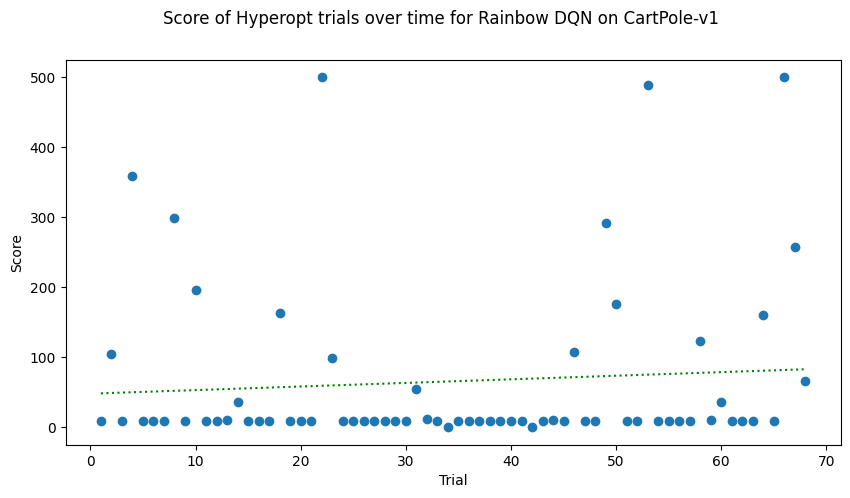

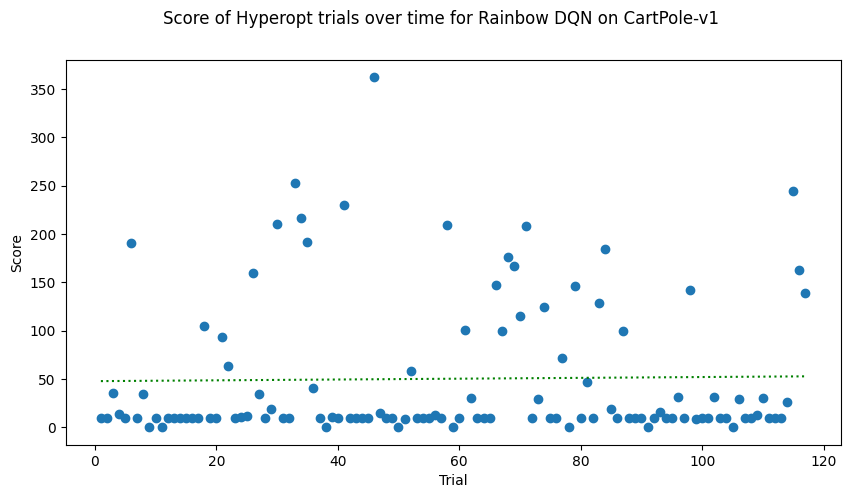

In [1]:
# Graphing the trials over time
from utils import plot_trials
import pickle
%matplotlib inline

data_dir = "./torch_choice_trials"
trials = pickle.load(open(f'{data_dir}/CartPole-v1_trials.p', 'rb'))
plot_trials(trials, "Carpole-v1_torch_trials_over_time")

data_dir = "./tensorflow_choice_trials"
trials = pickle.load(open(f'{data_dir}/CartPole-v1_trials.p', 'rb'))
# print(trials.trials)
plot_trials(trials, "Carpole-v1_tensorflow_trials_over_time")


In [4]:
import pickle 
import os 

viable_trial_threshold = 15
data_dir = "./torch_choice_trials"

trials = pickle.load(open(f'{data_dir}/CartPole-v1_trials.p', 'rb'))
print("Number of Trials", len(trials.trials))
losses = [-trial['result']['loss'] for trial in trials.trials]
losses.sort()
print("Losses", losses, len(losses), sum(losses)/len(losses))
viable_trials = [loss for loss in losses if loss > viable_trial_threshold]
print("Viable Trials", len(viable_trials)/len(losses))

viable_trials = []
for trial in os.listdir(f"{data_dir}/checkpoints"):
  if os.path.exists(f"{data_dir}/checkpoints/{trial}/step_9999/graphs_stats/stats.pkl"):
    stats = pickle.load(open(f'{data_dir}/checkpoints/{trial}/step_9999/graphs_stats/stats.pkl', 'rb'))
    max_score = 0
    for stat_dict in stats["test_score"]:
      if stat_dict["max_score"] > max_score:
        max_score = stat_dict["max_score"]
      if max_score > viable_trial_threshold:
        viable_trials.append(max_score)
        break
print("Viable Trials", len(viable_trials)/len(losses))


data_dir = "./tensorflow_choice_trials"
trials = pickle.load(open(f'{data_dir}/CartPole-v1_trials.p', 'rb'))
print("Number of Trials", len(trials.trials))
losses = [-trial['result']['loss'] for trial in trials.trials]
losses.sort()
print("Losses", losses, len(losses), sum(losses)/len(losses))
viable_trials = [loss for loss in losses if loss > viable_trial_threshold]
print("Viable Trials", len(viable_trials)/len(losses))


# TENSORFLOW TRIALS ARE ONLY 5000 STEPS
viable_trials = []
for trial in os.listdir(f"{data_dir}/checkpoints"):
  if os.path.exists(f"{data_dir}/checkpoints/{trial}/step_4999/graphs_stats/stats.pkl"):
    stats = pickle.load(open(f'{data_dir}/checkpoints/{trial}/step_4999/graphs_stats/stats.pkl', 'rb'))
    max_score = 0
    for stat_dict in stats["test_score"]:
      if stat_dict["max_score"] > max_score:
        max_score = stat_dict["max_score"]
      if max_score > viable_trial_threshold:
        viable_trials.append(max_score)
        break
print("Viable Trials", len(viable_trials)/len(losses))

Number of Trials 68
Losses [0, 0, 9.0, 9.0, 9.1, 9.1, 9.1, 9.1, 9.1, 9.2, 9.2, 9.2, 9.2, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.5, 9.5, 9.5, 9.5, 9.5, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.7, 9.8, 10.9, 11.2, 35.5, 35.5, 54.1, 65.6, 99.3, 104.2, 107.7, 123.3, 160.4, 162.5, 176.6, 195.5, 257.8, 292.0, 299.2, 358.8, 489.3, 500.0, 500.0] 68 65.61323529411764
Viable Trials 0.27941176470588236
Viable Trials 0.4117647058823529
Number of Trials 117
Losses [0, 0, 0, 0, 0, 0, 0, 0, 8.9, 9.0, 9.1, 9.1, 9.1, 9.1, 9.1, 9.1, 9.2, 9.2, 9.2, 9.2, 9.2, 9.2, 9.2, 9.2, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.6, 9.6, 9.6, 9.6, 9.6, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.8, 9.8, 9.8, 9.8, 9.9, 10.4, 10.7, 11.3, 12.3, 12.5, 13.2, 15.0, 15.3, 18.7, 19.0, 25.7, 29.1, 29.4, 29.8, 30.3, 30.8, 30.9, 33.9, 34.7, 35.9, 40.6, 46.5, 58.6, 63.1, 71.6, 93.8, 99.3, 99.5, 100.9, 

## Hyperopt with Torch and hp.uniform, hp.loguniform, etc...

In [1]:
import pickle
from hyperopt import hp
from hyperopt.pyll import scope
from utils import CategoricalCrossentropy, KLDivergence, generate_layer_widths
import gymnasium as gym 
import numpy as np

width_combinations = generate_layer_widths([32, 64, 128, 256, 512, 1024], 5)
# print(width_combinations)

search_space = {
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "orthogonal",
            ],
        ),
        "learning_rate": hp.qloguniform('learning_rate', np.log(0.00001), np.log(1.0), 0.00001),
        "adam_epsilon": hp.qloguniform('adam_epsilon', np.log(0.0003125), np.log(0.3125), 0.0003125),
        "loss_function": hp.choice(
            "loss_function", [CategoricalCrossentropy(), KLDivergence()]
        ),
        # NORMALIZATION?
        "transfer_interval": scope.int(hp.qloguniform('transfer_interval', np.log(10), np.log(2000), 10)),
        "replay_interval": hp.uniformint('replay_interval', 1, 12),
        "minibatch_size": scope.int(hp.quniform('minibatch_size', 16, 128, 16)),  ###########
        "replay_buffer_size": scope.int(hp.quniform('replay_buffer_size', 2000, 10000, 1000)),  #############
        "min_replay_buffer_size": scope.int(hp.quniform('min_replay_buffer_size', 125, 2000, 125)), 
        "n_step": hp.uniformint('n_step', 2, 10),
        "discount_factor": hp.qloguniform('discount_factor', np.log(0.9), np.log(0.999), 0.001),
        "atom_size": scope.int(hp.quniform('atom_size', 51, 81, 10) + 1),  #
        "conv_layers": hp.choice("conv_layers", [[]]),
        "dense_layers_widths": hp.choice("dense_layers_widths", width_combinations),
        "advantage_hidden_layers_widths": hp.choice(
            "advantage_hidden_layers_widths", width_combinations
        ),  #
        "value_hidden_layers_widths": hp.choice(
            "value_hidden_layers_widths", width_combinations
        ),  #
        "training_steps": hp.choice("training_steps", [10000]),
        "per_epsilon": hp.qloguniform('per_epsilon', np.log(0.00001), np.log(0.1), 0.00001),
        "per_alpha": hp.quniform('per_alpha', 0.05, 1.0, 0.05),
        "per_beta": hp.quniform('per_beta', 0.05, 1.0, 0.05),
        "clipnorm": hp.qloguniform('clipnorm', np.log(0.1), np.log(100.0), 0.1)
    }

initial_best_config = [{}]


pickle.dump(search_space, open("./search_spaces/torch_quantized_search_search_space.pkl", "wb"))
pickle.dump(initial_best_config, open("./search_spaces/torch_quantized_search_initial_best_config.pkl", "wb"))

%run ../../dqn/rainbow/hyperparameter_optimization.py ./search_spaces/torch_quantized_search_search_space.pkl ./search_spaces/torch_quantized_search_initial_best_config.pkl CartPole-v1_quantized_search

Found saved Trials! Loading...
Rerunning from 30 trials to 94 (+64) trials
Params:  {'adam_epsilon': 0.023125, 'advantage_hidden_layers_widths': (32, 32, 32), 'atom_size': 51, 'clipnorm': 1.7000000000000002, 'conv_layers': (), 'dense_layers_widths': (32, 64, 512), 'discount_factor': 0.991, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.00813, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 250, 'minibatch_size': 16, 'n_step': 9, 'per_alpha': 1.0, 'per_beta': 0.45, 'per_epsilon': 0.00464, 'replay_buffer_size': 9000, 'replay_interval': 6, 'training_steps': 10000, 'transfer_interval': 2000, 'value_hidden_layers_widths': (64, 512, 512, 512)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights     : True
Using         training_steps                : 10000
Using         adam_epsilon                  : 0.023125
Using         learning_rate                 : 0.00813
Using         clipnorm                  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_31_CartPole-v1/333/CartPole-v1_quantized_search_31_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_31_CartPole-v1/333/CartPole-v1_quantized_search_31_CartPole-v1-episode-4.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_31_CartPole-v1/333/CartPole-v1_quantized_search_31_CartPole-v1-episode-4.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


score:  8.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_31_CartPole-v1/666/CartPole-v1_quantized_search_31_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_31_CartPole-v1/666/CartPole-v1_quantized_search_31_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_31_CartPole-v1/666/CartPole-v1_quantized_search_31_CartPole-v1-episode-9.mp4
score:  10.0
score:  9.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_31_CartPole-v1/999/CartPole-v1_quantized_search_31_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_31_CartPole-v1/999/CartPole-v1_quantized_search_31_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_31_CartPole-v1/999/CartPole-v1_quantized_search_31_CartPole-v1-episode-14.mp4
score:  9.0
score:  8.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_31_CartPole-v1/1332/CartPole-v1_quantized_search_31_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_31_CartPole-v1/1332/CartPole-v1_quantized_search_31_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_31_CartPole-v1/1332/CartPole-v1_quantized_search_31_CartPole-v1-episode-19.mp4
score:  10.0
score:  9.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_31_CartPole-v1/1665/CartPole-v1_quantized_search_31_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_31_CartPole-v1/1665/CartPole-v1_quantized_search_31_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_31_CartPole-v1/1665/CartPole-v1_quantized_search_31_CartPole-v1-episode-24.mp4
score:  10.0
score:  8.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_31_CartPole-v1/1998/CartPole-v1_quantized_search_31_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_31_CartPole-v1/1998/CartPole-v1_quantized_search_31_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_31_CartPole-v1/1998/CartPole-v1_quantized_search_31_CartPole-v1-episode-29.mp4
score:  9.0
score:  9.0
score:  8.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_31_CartPole-v1/2331/CartPole-v1_quantized_search_31_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_31_CartPole-v1/2331/CartPole-v1_quantized_search_31_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_31_CartPole-v1/2331/CartPole-v1_quantized_search_31_CartPole-v1-episode-34.mp4
score:  9.0
score:  8.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_31_CartPole-v1/2664/CartPole-v1_quantized_search_31_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_31_CartPole-v1/2664/CartPole-v1_quantized_search_31_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_31_CartPole-v1/2664/CartPole-v1_quantized_search_31_CartPole-v1-episode-39.mp4
score:  10.0
score:  8.0
score:  8.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_31_CartPole-v1/2997/CartPole-v1_quantized_search_31_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_31_CartPole-v1/2997/CartPole-v1_quantized_search_31_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_31_CartPole-v1/2997/CartPole-v1_quantized_search_31_CartPole-v1-episode-44.mp4
score:  9.0
score:  9.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_31_CartPole-v1/3330/CartPole-v1_quantized_search_31_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_31_CartPole-v1/3330/CartPole-v1_quantized_search_31_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_31_CartPole-v1/3330/CartPole-v1_quantized_search_31_CartPole-v1-episode-49.mp4
score:  9.0
score:  10.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_31_CartPole-v1/3663/CartPole-v1_quantized_search_31_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_31_CartPole-v1/3663/CartPole-v1_quantized_search_31_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_31_CartPole-v1/3663/CartPole-v1_quantized_search_31_CartPole-v1-episode-54.mp4
score:  10.0
score:  10.0
score:  9.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_31_CartPole-v1/3996/CartPole-v1_quantized_search_31_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_31_CartPole-v1/3996/CartPole-v1_quantized_search_31_CartPole-v1-episode-59.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_31_CartPole-v1/3996/CartPole-v1_quantized_search_31_CartPole-v1-episode-59.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_31_CartPole-v1/4329/CartPole-v1_quantized_search_31_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_31_CartPole-v1/4329/CartPole-v1_quantized_search_31_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_31_CartPole-v1/4329/CartPole-v1_quantized_search_31_CartPole-v1-episode-64.mp4
score:  10.0
score:  9.0
score:  8.0
score:  8.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_31_CartPole-v1/4662/CartPole-v1_quantized_search_31_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_31_CartPole-v1/4662/CartPole-v1_quantized_search_31_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_31_CartPole-v1/4662/CartPole-v1_quantized_search_31_CartPole-v1-episode-69.mp4
score:  10.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_31_CartPole-v1/4995/CartPole-v1_quantized_search_31_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_31_CartPole-v1/4995/CartPole-v1_quantized_search_31_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_31_CartPole-v1/4995/CartPole-v1_quantized_search_31_CartPole-v1-episode-74.mp4
score:  8.0
score:  8.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_31_CartPole-v1/5328/CartPole-v1_quantized_search_31_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_31_CartPole-v1/5328/CartPole-v1_quantized_search_31_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_31_CartPole-v1/5328/CartPole-v1_quantized_search_31_CartPole-v1-episode-79.mp4
score:  10.0
score:  8.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_31_CartPole-v1/5661/CartPole-v1_quantized_search_31_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_31_CartPole-v1/5661/CartPole-v1_quantized_search_31_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_31_CartPole-v1/5661/CartPole-v1_quantized_search_31_CartPole-v1-episode-84.mp4
score:  9.0
score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_31_CartPole-v1/5994/CartPole-v1_quantized_search_31_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_31_CartPole-v1/5994/CartPole-v1_quantized_search_31_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_31_CartPole-v1/5994/CartPole-v1_quantized_search_31_CartPole-v1-episode-89.mp4
score:  9.0
score:  10.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_31_CartPole-v1/6327/CartPole-v1_quantized_search_31_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_31_CartPole-v1/6327/CartPole-v1_quantized_search_31_CartPole-v1-episode-94.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_31_CartPole-v1/6327/CartPole-v1_quantized_search_31_CartPole-v1-episode-94.mp4
score:  8.0
score:  9.0
score:  11.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_31_CartPole-v1/6660/CartPole-v1_quantized_search_31_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_31_CartPole-v1/6660/CartPole-v1_quantized_search_31_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_31_CartPole-v1/6660/CartPole-v1_quantized_search_31_CartPole-v1-episode-99.mp4
score:  10.0
score:  10.0
score:  10.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_31_CartPole-v1/6993/CartPole-v1_quantized_search_31_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_31_CartPole-v1/6993/CartPole-v1_quantized_search_31_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_31_CartPole-v1/6993/CartPole-v1_quantized_search_31_CartPole-v1-episode-104.mp4
score:  9.0
score:  10.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_31_CartPole-v1/7326/CartPole-v1_quantized_search_31_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_31_CartPole-v1/7326/CartPole-v1_quantized_search_31_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_31_CartPole-v1/7326/CartPole-v1_quantized_search_31_CartPole-v1-episode-109.mp4
score:  9.0
score:  10.0
score:  9.0
score:  10.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_31_CartPole-v1/7659/CartPole-v1_quantized_search_31_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_31_CartPole-v1/7659/CartPole-v1_quantized_search_31_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_31_CartPole-v1/7659/CartPole-v1_quantized_search_31_CartPole-v1-episode-114.mp4
score:  10.0
score:  9.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_31_CartPole-v1/7992/CartPole-v1_quantized_search_31_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_31_CartPole-v1/7992/CartPole-v1_quantized_search_31_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_31_CartPole-v1/7992/CartPole-v1_quantized_search_31_CartPole-v1-episode-119.mp4
score:  10.0
score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_31_CartPole-v1/8325/CartPole-v1_quantized_search_31_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_31_CartPole-v1/8325/CartPole-v1_quantized_search_31_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_31_CartPole-v1/8325/CartPole-v1_quantized_search_31_CartPole-v1-episode-124.mp4
score:  9.0
score:  10.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_31_CartPole-v1/8658/CartPole-v1_quantized_search_31_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_31_CartPole-v1/8658/CartPole-v1_quantized_search_31_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_31_CartPole-v1/8658/CartPole-v1_quantized_search_31_CartPole-v1-episode-129.mp4
score:  10.0
score:  9.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_31_CartPole-v1/8991/CartPole-v1_quantized_search_31_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_31_CartPole-v1/8991/CartPole-v1_quantized_search_31_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_31_CartPole-v1/8991/CartPole-v1_quantized_search_31_CartPole-v1-episode-134.mp4
score:  9.0
score:  9.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_31_CartPole-v1/9324/CartPole-v1_quantized_search_31_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_31_CartPole-v1/9324/CartPole-v1_quantized_search_31_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_31_CartPole-v1/9324/CartPole-v1_quantized_search_31_CartPole-v1-episode-139.mp4
score:  10.0
score:  9.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_31_CartPole-v1/9657/CartPole-v1_quantized_search_31_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_31_CartPole-v1/9657/CartPole-v1_quantized_search_31_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_31_CartPole-v1/9657/CartPole-v1_quantized_search_31_CartPole-v1-episode-144.mp4
score:  9.0
score:  8.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_31_CartPole-v1/9990/CartPole-v1_quantized_search_31_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_31_CartPole-v1/9990/CartPole-v1_quantized_search_31_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_31_CartPole-v1/9990/CartPole-v1_quantized_search_31_CartPole-v1-episode-149.mp4
score:  10.0
score:  11.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_31_CartPole-v1/9999/CartPole-v1_quantized_search_31_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_31_CartPole-v1/9999/CartPole-v1_quantized_search_31_CartPole-v1-episode-154.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_31_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_31_CartPole-v1/9999/CartPole-v1_quantized_search_31_CartPole-v1-episode-154.mp4
score:  9.0
Training complete
score:  8.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_31_CartPole-v1/5000/CartPole-v1_quantized_search_31_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_31_CartPole-v1/5000/CartPole-v1_quantized_search_31_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_31_CartPole-v1/5000/CartPole-v1_quantized_search_31_CartPole-v1-episode-159.mp4
score:  8.0
score:  10.0


score:  10.0
score:  11.0
score:  10.0
score:  9.0
parallel programs done
Params:  {'adam_epsilon': 0.0021875, 'advantage_hidden_layers_widths': (32, 64, 64, 512), 'atom_size': 51, 'clipnorm': 0.6000000000000001, 'conv_layers': (), 'dense_layers_widths': (128, 128, 256), 'discount_factor': 0.973, 'kernel_initializer': 'glorot_uniform', 'learning_rate': 0.37665000000000004, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1000, 'minibatch_size': 96, 'n_step': 8, 'per_alpha': 0.65, 'per_beta': 0.25, 'per_epsilon': 0.04222, 'replay_buffer_size': 5000, 'replay_interval': 10, 'training_steps': 10000, 'transfer_interval': 360, 'value_hidden_layers_widths': (64, 64)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights     : True
Using         training_steps                : 10000
Using         adam_epsilon                  : 0.0021875
Using         learning_rate                 : 0.37665000000000004
Using        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  9.0
score:  8.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_32_CartPole-v1/333/CartPole-v1_quantized_search_32_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_32_CartPole-v1/333/CartPole-v1_quantized_search_32_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_32_CartPole-v1/333/CartPole-v1_quantized_search_32_CartPole-v1-episode-4.mp4
score:  10.0
score:  10.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_32_CartPole-v1/666/CartPole-v1_quantized_search_32_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_32_CartPole-v1/666/CartPole-v1_quantized_search_32_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_32_CartPole-v1/666/CartPole-v1_quantized_search_32_CartPole-v1-episode-9.mp4
score:  9.0
score:  9.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_32_CartPole-v1/999/CartPole-v1_quantized_search_32_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_32_CartPole-v1/999/CartPole-v1_quantized_search_32_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_32_CartPole-v1/999/CartPole-v1_quantized_search_32_CartPole-v1-episode-14.mp4
score:  9.0
score:  10.0
score:  10.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_32_CartPole-v1/1332/CartPole-v1_quantized_search_32_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_32_CartPole-v1/1332/CartPole-v1_quantized_search_32_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_32_CartPole-v1/1332/CartPole-v1_quantized_search_32_CartPole-v1-episode-19.mp4
score:  10.0
score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_32_CartPole-v1/1665/CartPole-v1_quantized_search_32_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_32_CartPole-v1/1665/CartPole-v1_quantized_search_32_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_32_CartPole-v1/1665/CartPole-v1_quantized_search_32_CartPole-v1-episode-24.mp4
score:  10.0
score:  10.0
score:  9.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_32_CartPole-v1/1998/CartPole-v1_quantized_search_32_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_32_CartPole-v1/1998/CartPole-v1_quantized_search_32_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_32_CartPole-v1/1998/CartPole-v1_quantized_search_32_CartPole-v1-episode-29.mp4
score:  10.0
score:  10.0
score:  10.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_32_CartPole-v1/2331/CartPole-v1_quantized_search_32_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_32_CartPole-v1/2331/CartPole-v1_quantized_search_32_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_32_CartPole-v1/2331/CartPole-v1_quantized_search_32_CartPole-v1-episode-34.mp4
score:  10.0
score:  10.0
score:  9.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_32_CartPole-v1/2664/CartPole-v1_quantized_search_32_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_32_CartPole-v1/2664/CartPole-v1_quantized_search_32_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_32_CartPole-v1/2664/CartPole-v1_quantized_search_32_CartPole-v1-episode-39.mp4
score:  10.0
score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_32_CartPole-v1/2997/CartPole-v1_quantized_search_32_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_32_CartPole-v1/2997/CartPole-v1_quantized_search_32_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_32_CartPole-v1/2997/CartPole-v1_quantized_search_32_CartPole-v1-episode-44.mp4
score:  9.0
score:  9.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_32_CartPole-v1/3330/CartPole-v1_quantized_search_32_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_32_CartPole-v1/3330/CartPole-v1_quantized_search_32_CartPole-v1-episode-49.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_32_CartPole-v1/3330/CartPole-v1_quantized_search_32_CartPole-v1-episode-49.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_32_CartPole-v1/3663/CartPole-v1_quantized_search_32_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_32_CartPole-v1/3663/CartPole-v1_quantized_search_32_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_32_CartPole-v1/3663/CartPole-v1_quantized_search_32_CartPole-v1-episode-54.mp4
score:  8.0
score:  10.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_32_CartPole-v1/3996/CartPole-v1_quantized_search_32_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_32_CartPole-v1/3996/CartPole-v1_quantized_search_32_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_32_CartPole-v1/3996/CartPole-v1_quantized_search_32_CartPole-v1-episode-59.mp4
score:  10.0
score:  8.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_32_CartPole-v1/4329/CartPole-v1_quantized_search_32_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_32_CartPole-v1/4329/CartPole-v1_quantized_search_32_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_32_CartPole-v1/4329/CartPole-v1_quantized_search_32_CartPole-v1-episode-64.mp4
score:  9.0
score:  9.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_32_CartPole-v1/4662/CartPole-v1_quantized_search_32_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_32_CartPole-v1/4662/CartPole-v1_quantized_search_32_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_32_CartPole-v1/4662/CartPole-v1_quantized_search_32_CartPole-v1-episode-69.mp4
score:  10.0
score:  8.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_32_CartPole-v1/4995/CartPole-v1_quantized_search_32_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_32_CartPole-v1/4995/CartPole-v1_quantized_search_32_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_32_CartPole-v1/4995/CartPole-v1_quantized_search_32_CartPole-v1-episode-74.mp4
score:  9.0
score:  8.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_32_CartPole-v1/5328/CartPole-v1_quantized_search_32_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_32_CartPole-v1/5328/CartPole-v1_quantized_search_32_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_32_CartPole-v1/5328/CartPole-v1_quantized_search_32_CartPole-v1-episode-79.mp4
score:  10.0
score:  9.0
score:  10.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_32_CartPole-v1/5661/CartPole-v1_quantized_search_32_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_32_CartPole-v1/5661/CartPole-v1_quantized_search_32_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_32_CartPole-v1/5661/CartPole-v1_quantized_search_32_CartPole-v1-episode-84.mp4
score:  10.0
score:  10.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_32_CartPole-v1/5994/CartPole-v1_quantized_search_32_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_32_CartPole-v1/5994/CartPole-v1_quantized_search_32_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_32_CartPole-v1/5994/CartPole-v1_quantized_search_32_CartPole-v1-episode-89.mp4
score:  10.0
score:  10.0
score:  8.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_32_CartPole-v1/6327/CartPole-v1_quantized_search_32_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_32_CartPole-v1/6327/CartPole-v1_quantized_search_32_CartPole-v1-episode-94.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_32_CartPole-v1/6327/CartPole-v1_quantized_search_32_CartPole-v1-episode-94.mp4
score:  9.0
score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_32_CartPole-v1/6660/CartPole-v1_quantized_search_32_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_32_CartPole-v1/6660/CartPole-v1_quantized_search_32_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_32_CartPole-v1/6660/CartPole-v1_quantized_search_32_CartPole-v1-episode-99.mp4
score:  9.0
score:  9.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_32_CartPole-v1/6993/CartPole-v1_quantized_search_32_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_32_CartPole-v1/6993/CartPole-v1_quantized_search_32_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_32_CartPole-v1/6993/CartPole-v1_quantized_search_32_CartPole-v1-episode-104.mp4
score:  10.0
score:  11.0
score:  11.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_32_CartPole-v1/7326/CartPole-v1_quantized_search_32_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_32_CartPole-v1/7326/CartPole-v1_quantized_search_32_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_32_CartPole-v1/7326/CartPole-v1_quantized_search_32_CartPole-v1-episode-109.mp4
score:  9.0
score:  9.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_32_CartPole-v1/7659/CartPole-v1_quantized_search_32_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_32_CartPole-v1/7659/CartPole-v1_quantized_search_32_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_32_CartPole-v1/7659/CartPole-v1_quantized_search_32_CartPole-v1-episode-114.mp4
score:  10.0
score:  8.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_32_CartPole-v1/7992/CartPole-v1_quantized_search_32_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_32_CartPole-v1/7992/CartPole-v1_quantized_search_32_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_32_CartPole-v1/7992/CartPole-v1_quantized_search_32_CartPole-v1-episode-119.mp4
score:  10.0
score:  9.0
score:  10.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_32_CartPole-v1/8325/CartPole-v1_quantized_search_32_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_32_CartPole-v1/8325/CartPole-v1_quantized_search_32_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_32_CartPole-v1/8325/CartPole-v1_quantized_search_32_CartPole-v1-episode-124.mp4
score:  8.0
score:  9.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_32_CartPole-v1/8658/CartPole-v1_quantized_search_32_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_32_CartPole-v1/8658/CartPole-v1_quantized_search_32_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_32_CartPole-v1/8658/CartPole-v1_quantized_search_32_CartPole-v1-episode-129.mp4
score:  8.0
score:  8.0
score:  9.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_32_CartPole-v1/8991/CartPole-v1_quantized_search_32_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_32_CartPole-v1/8991/CartPole-v1_quantized_search_32_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_32_CartPole-v1/8991/CartPole-v1_quantized_search_32_CartPole-v1-episode-134.mp4
score:  8.0
score:  10.0
score:  8.0
score:  11.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_32_CartPole-v1/9324/CartPole-v1_quantized_search_32_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_32_CartPole-v1/9324/CartPole-v1_quantized_search_32_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_32_CartPole-v1/9324/CartPole-v1_quantized_search_32_CartPole-v1-episode-139.mp4
score:  9.0
score:  9.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_32_CartPole-v1/9657/CartPole-v1_quantized_search_32_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_32_CartPole-v1/9657/CartPole-v1_quantized_search_32_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_32_CartPole-v1/9657/CartPole-v1_quantized_search_32_CartPole-v1-episode-144.mp4
score:  10.0
score:  10.0
score:  8.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_32_CartPole-v1/9990/CartPole-v1_quantized_search_32_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_32_CartPole-v1/9990/CartPole-v1_quantized_search_32_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_32_CartPole-v1/9990/CartPole-v1_quantized_search_32_CartPole-v1-episode-149.mp4
score:  8.0
score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_32_CartPole-v1/9999/CartPole-v1_quantized_search_32_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_32_CartPole-v1/9999/CartPole-v1_quantized_search_32_CartPole-v1-episode-154.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_32_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_32_CartPole-v1/9999/CartPole-v1_quantized_search_32_CartPole-v1-episode-154.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Training complete
score:  9.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_32_CartPole-v1/5000/CartPole-v1_quantized_search_32_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_32_CartPole-v1/5000/CartPole-v1_quantized_search_32_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_32_CartPole-v1/5000/CartPole-v1_quantized_search_32_CartPole-v1-episode-159.mp4
score:  9.0
score:  10.0
score:  8.0
score:  10.0
score:  9.0
score:  9.0
parallel programs done


Params:  {'adam_epsilon': 0.00125, 'advantage_hidden_layers_widths': (64, 128, 128), 'atom_size': 51, 'clipnorm': 7.1000000000000005, 'conv_layers': (), 'dense_layers_widths': (32, 256, 256, 512), 'discount_factor': 0.9530000000000001, 'kernel_initializer': 'glorot_uniform', 'learning_rate': 0.00035000000000000005, 'loss_function': <utils.utils.CategoricalCrossentropy object at 0x288bc76e0>, 'min_replay_buffer_size': 625, 'minibatch_size': 48, 'n_step': 7, 'per_alpha': 0.65, 'per_beta': 0.4, 'per_epsilon': 0.01701, 'replay_buffer_size': 9000, 'replay_interval': 2, 'training_steps': 10000, 'transfer_interval': 150, 'value_hidden_layers_widths': (128, 128, 256, 256)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights     : True
Using         training_steps                : 10000
Using         adam_epsilon                  : 0.00125
Using         learning_rate                 : 0.00035000000000000005
Using         clipnorm                      : 7.100

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  10.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_33_CartPole-v1/333/CartPole-v1_quantized_search_33_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_33_CartPole-v1/333/CartPole-v1_quantized_search_33_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_33_CartPole-v1/333/CartPole-v1_quantized_search_33_CartPole-v1-episode-4.mp4
score:  9.0
score:  10.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_33_CartPole-v1/666/CartPole-v1_quantized_search_33_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_33_CartPole-v1/666/CartPole-v1_quantized_search_33_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_33_CartPole-v1/666/CartPole-v1_quantized_search_33_CartPole-v1-episode-9.mp4
score:  10.0
score:  10.0
score:  9.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_33_CartPole-v1/999/CartPole-v1_quantized_search_33_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_33_CartPole-v1/999/CartPole-v1_quantized_search_33_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_33_CartPole-v1/999/CartPole-v1_quantized_search_33_CartPole-v1-episode-14.mp4
score:  10.0
score:  10.0
score:  8.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_33_CartPole-v1/1332/CartPole-v1_quantized_search_33_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_33_CartPole-v1/1332/CartPole-v1_quantized_search_33_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_33_CartPole-v1/1332/CartPole-v1_quantized_search_33_CartPole-v1-episode-19.mp4
score:  8.0
score:  8.0
score:  8.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_33_CartPole-v1/1665/CartPole-v1_quantized_search_33_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_33_CartPole-v1/1665/CartPole-v1_quantized_search_33_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_33_CartPole-v1/1665/CartPole-v1_quantized_search_33_CartPole-v1-episode-24.mp4
score:  10.0
score:  10.0
score:  9.0
score:  8.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_33_CartPole-v1/1998/CartPole-v1_quantized_search_33_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_33_CartPole-v1/1998/CartPole-v1_quantized_search_33_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_33_CartPole-v1/1998/CartPole-v1_quantized_search_33_CartPole-v1-episode-29.mp4
score:  10.0
score:  10.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_33_CartPole-v1/2331/CartPole-v1_quantized_search_33_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_33_CartPole-v1/2331/CartPole-v1_quantized_search_33_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_33_CartPole-v1/2331/CartPole-v1_quantized_search_33_CartPole-v1-episode-34.mp4
score:  10.0
score:  19.0
score:  20.0
score:  13.0
score:  14.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_33_CartPole-v1/2664/CartPole-v1_quantized_search_33_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_33_CartPole-v1/2664/CartPole-v1_quantized_search_33_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_33_CartPole-v1/2664/CartPole-v1_quantized_search_33_CartPole-v1-episode-39.mp4
score:  15.0
score:  10.0
score:  8.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_33_CartPole-v1/2997/CartPole-v1_quantized_search_33_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_33_CartPole-v1/2997/CartPole-v1_quantized_search_33_CartPole-v1-episode-44.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_33_CartPole-v1/2997/CartPole-v1_quantized_search_33_CartPole-v1-episode-44.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  15.0
score:  13.0
score:  18.0
score:  20.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_33_CartPole-v1/3330/CartPole-v1_quantized_search_33_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_33_CartPole-v1/3330/CartPole-v1_quantized_search_33_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_33_CartPole-v1/3330/CartPole-v1_quantized_search_33_CartPole-v1-episode-49.mp4
score:  15.0
score:  18.0
score:  21.0
score:  15.0
score:  17.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_33_CartPole-v1/3663/CartPole-v1_quantized_search_33_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_33_CartPole-v1/3663/CartPole-v1_quantized_search_33_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_33_CartPole-v1/3663/CartPole-v1_quantized_search_33_CartPole-v1-episode-54.mp4
score:  17.0
score:  10.0
score:  9.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_33_CartPole-v1/3996/CartPole-v1_quantized_search_33_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_33_CartPole-v1/3996/CartPole-v1_quantized_search_33_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_33_CartPole-v1/3996/CartPole-v1_quantized_search_33_CartPole-v1-episode-59.mp4
score:  10.0
score:  13.0
score:  11.0
score:  14.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_33_CartPole-v1/4329/CartPole-v1_quantized_search_33_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_33_CartPole-v1/4329/CartPole-v1_quantized_search_33_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_33_CartPole-v1/4329/CartPole-v1_quantized_search_33_CartPole-v1-episode-64.mp4
score:  11.0
score:  12.0
score:  13.0
score:  10.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_33_CartPole-v1/4662/CartPole-v1_quantized_search_33_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_33_CartPole-v1/4662/CartPole-v1_quantized_search_33_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_33_CartPole-v1/4662/CartPole-v1_quantized_search_33_CartPole-v1-episode-69.mp4
score:  10.0
score:  17.0
score:  27.0
score:  33.0
score:  25.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_33_CartPole-v1/4995/CartPole-v1_quantized_search_33_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_33_CartPole-v1/4995/CartPole-v1_quantized_search_33_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_33_CartPole-v1/4995/CartPole-v1_quantized_search_33_CartPole-v1-episode-74.mp4
score:  17.0
score:  31.0
score:  30.0
score:  26.0
score:  26.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_33_CartPole-v1/5328/CartPole-v1_quantized_search_33_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_33_CartPole-v1/5328/CartPole-v1_quantized_search_33_CartPole-v1-episode-79.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_33_CartPole-v1/5328/CartPole-v1_quantized_search_33_CartPole-v1-episode-79.mp4
score:  34.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  181.0
score:  173.0
score:  193.0
score:  196.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_33_CartPole-v1/5661/CartPole-v1_quantized_search_33_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_33_CartPole-v1/5661/CartPole-v1_quantized_search_33_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_33_CartPole-v1/5661/CartPole-v1_quantized_search_33_CartPole-v1-episode-84.mp4
score:  198.0
score:  106.0
score:  89.0
score:  119.0
score:  68.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_33_CartPole-v1/5994/CartPole-v1_quantized_search_33_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_33_CartPole-v1/5994/CartPole-v1_quantized_search_33_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_33_CartPole-v1/5994/CartPole-v1_quantized_search_33_CartPole-v1-episode-89.mp4
score:  71.0
score:  78.0
score:  77.0
score:  75.0
score:  90.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_33_CartPole-v1/6327/CartPole-v1_quantized_search_33_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_33_CartPole-v1/6327/CartPole-v1_quantized_search_33_CartPole-v1-episode-94.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_33_CartPole-v1/6327/CartPole-v1_quantized_search_33_CartPole-v1-episode-94.mp4
score:  82.0
score:  158.0
score:  389.0
score:  332.0
score:  139.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_33_CartPole-v1/6660/CartPole-v1_quantized_search_33_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_33_CartPole-v1/6660/CartPole-v1_quantized_search_33_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_33_CartPole-v1/6660/CartPole-v1_quantized_search_33_CartPole-v1-episode-99.mp4
score:  205.0
score:  150.0
score:  148.0
score:  149.0
score:  143.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_33_CartPole-v1/6993/CartPole-v1_quantized_search_33_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_33_CartPole-v1/6993/CartPole-v1_quantized_search_33_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_33_CartPole-v1/6993/CartPole-v1_quantized_search_33_CartPole-v1-episode-104.mp4
score:  156.0
score:  52.0
score:  53.0
score:  55.0
score:  54.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_33_CartPole-v1/7326/CartPole-v1_quantized_search_33_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_33_CartPole-v1/7326/CartPole-v1_quantized_search_33_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_33_CartPole-v1/7326/CartPole-v1_quantized_search_33_CartPole-v1-episode-109.mp4
score:  57.0
score:  91.0
score:  92.0
score:  93.0
score:  88.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_33_CartPole-v1/7659/CartPole-v1_quantized_search_33_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_33_CartPole-v1/7659/CartPole-v1_quantized_search_33_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_33_CartPole-v1/7659/CartPole-v1_quantized_search_33_CartPole-v1-episode-114.mp4
score:  95.0
score:  102.0
score:  102.0
score:  102.0
score:  94.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_33_CartPole-v1/7992/CartPole-v1_quantized_search_33_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_33_CartPole-v1/7992/CartPole-v1_quantized_search_33_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_33_CartPole-v1/7992/CartPole-v1_quantized_search_33_CartPole-v1-episode-119.mp4
score:  110.0
score:  94.0
score:  100.0
score:  110.0
score:  113.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_33_CartPole-v1/8325/CartPole-v1_quantized_search_33_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_33_CartPole-v1/8325/CartPole-v1_quantized_search_33_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_33_CartPole-v1/8325/CartPole-v1_quantized_search_33_CartPole-v1-episode-124.mp4
score:  115.0
score:  142.0
score:  141.0
score:  110.0
score:  124.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_33_CartPole-v1/8658/CartPole-v1_quantized_search_33_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_33_CartPole-v1/8658/CartPole-v1_quantized_search_33_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_33_CartPole-v1/8658/CartPole-v1_quantized_search_33_CartPole-v1-episode-129.mp4
score:  119.0
score:  131.0
score:  170.0
score:  131.0
score:  175.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_33_CartPole-v1/8991/CartPole-v1_quantized_search_33_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_33_CartPole-v1/8991/CartPole-v1_quantized_search_33_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_33_CartPole-v1/8991/CartPole-v1_quantized_search_33_CartPole-v1-episode-134.mp4
score:  150.0
score:  197.0
score:  178.0
score:  213.0
score:  185.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_33_CartPole-v1/9324/CartPole-v1_quantized_search_33_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_33_CartPole-v1/9324/CartPole-v1_quantized_search_33_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_33_CartPole-v1/9324/CartPole-v1_quantized_search_33_CartPole-v1-episode-139.mp4
score:  214.0
score:  188.0
score:  170.0
score:  171.0
score:  194.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_33_CartPole-v1/9657/CartPole-v1_quantized_search_33_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_33_CartPole-v1/9657/CartPole-v1_quantized_search_33_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_33_CartPole-v1/9657/CartPole-v1_quantized_search_33_CartPole-v1-episode-144.mp4
score:  164.0
score:  222.0
score:  168.0
score:  256.0
score:  172.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_33_CartPole-v1/9990/CartPole-v1_quantized_search_33_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_33_CartPole-v1/9990/CartPole-v1_quantized_search_33_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_33_CartPole-v1/9990/CartPole-v1_quantized_search_33_CartPole-v1-episode-149.mp4
score:  161.0
score:  175.0
score:  188.0
score:  171.0
score:  185.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_33_CartPole-v1/9999/CartPole-v1_quantized_search_33_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_33_CartPole-v1/9999/CartPole-v1_quantized_search_33_CartPole-v1-episode-154.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_33_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_33_CartPole-v1/9999/CartPole-v1_quantized_search_33_CartPole-v1-episode-154.mp4
score:  188.0
Training complete
score:  180.0
score:  177.0
score:  186.0
score:  195.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_33_CartPole-v1/5000/CartPole-v1_quantized_search_33_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_33_CartPole-v1/5000/CartPole-v1_quantized_search_33_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_33_CartPole-v1/5000/CartPole-v1_quantized_search_33_CartPole-v1-episode-159.mp4
score:  194.0
score:  176.0
score:  184.0
score:  190.0
score:  186.0
score:  207.0
parallel programs done
Params:  {'adam_epsilon': 0.00375, 'advantage_hidden_layers_widths': (32, 32, 32), 'atom_size': 51, 'clipnorm': 0.2, 'conv_layers': (), 'dense_layers_widths': (1024, 1024), 'discount_factor': 0.975, 'kernel_initializer': 'orthogonal', 'learning_rate': 1e-05, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1250, 'minibatch_size': 80, 'n_step': 10, 'per_alpha': 0.8, 'per_beta': 0.35000000000000003, 'per_epsilon': 0.006070000000000001, 'replay_buffer_size': 4000, 'replay_interval': 5, 'training_steps': 10000, 'transfer_interval': 200, 'value_hidden_layers_widths': (64, 64)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights     : True


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_34_CartPole-v1/333/CartPole-v1_quantized_search_34_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_34_CartPole-v1/333/CartPole-v1_quantized_search_34_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_34_CartPole-v1/333/CartPole-v1_quantized_search_34_CartPole-v1-episode-4.mp4
score:  10.0
score:  10.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_34_CartPole-v1/666/CartPole-v1_quantized_search_34_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_34_CartPole-v1/666/CartPole-v1_quantized_search_34_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_34_CartPole-v1/666/CartPole-v1_quantized_search_34_CartPole-v1-episode-9.mp4
score:  10.0
score:  10.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_34_CartPole-v1/999/CartPole-v1_quantized_search_34_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_34_CartPole-v1/999/CartPole-v1_quantized_search_34_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_34_CartPole-v1/999/CartPole-v1_quantized_search_34_CartPole-v1-episode-14.mp4
score:  9.0
score:  9.0
score:  10.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_34_CartPole-v1/1332/CartPole-v1_quantized_search_34_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_34_CartPole-v1/1332/CartPole-v1_quantized_search_34_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_34_CartPole-v1/1332/CartPole-v1_quantized_search_34_CartPole-v1-episode-19.mp4
score:  9.0
score:  10.0
score:  8.0
score:  9.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_34_CartPole-v1/1665/CartPole-v1_quantized_search_34_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_34_CartPole-v1/1665/CartPole-v1_quantized_search_34_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_34_CartPole-v1/1665/CartPole-v1_quantized_search_34_CartPole-v1-episode-24.mp4
score:  10.0
score:  10.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_34_CartPole-v1/1998/CartPole-v1_quantized_search_34_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_34_CartPole-v1/1998/CartPole-v1_quantized_search_34_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_34_CartPole-v1/1998/CartPole-v1_quantized_search_34_CartPole-v1-episode-29.mp4
score:  9.0
score:  10.0
score:  8.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_34_CartPole-v1/2331/CartPole-v1_quantized_search_34_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_34_CartPole-v1/2331/CartPole-v1_quantized_search_34_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_34_CartPole-v1/2331/CartPole-v1_quantized_search_34_CartPole-v1-episode-34.mp4
score:  10.0
score:  9.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_34_CartPole-v1/2664/CartPole-v1_quantized_search_34_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_34_CartPole-v1/2664/CartPole-v1_quantized_search_34_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_34_CartPole-v1/2664/CartPole-v1_quantized_search_34_CartPole-v1-episode-39.mp4
score:  8.0
score:  9.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_34_CartPole-v1/2997/CartPole-v1_quantized_search_34_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_34_CartPole-v1/2997/CartPole-v1_quantized_search_34_CartPole-v1-episode-44.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_34_CartPole-v1/2997/CartPole-v1_quantized_search_34_CartPole-v1-episode-44.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  8.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_34_CartPole-v1/3330/CartPole-v1_quantized_search_34_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_34_CartPole-v1/3330/CartPole-v1_quantized_search_34_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_34_CartPole-v1/3330/CartPole-v1_quantized_search_34_CartPole-v1-episode-49.mp4
score:  10.0
score:  8.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_34_CartPole-v1/3663/CartPole-v1_quantized_search_34_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_34_CartPole-v1/3663/CartPole-v1_quantized_search_34_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_34_CartPole-v1/3663/CartPole-v1_quantized_search_34_CartPole-v1-episode-54.mp4
score:  10.0
score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_34_CartPole-v1/3996/CartPole-v1_quantized_search_34_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_34_CartPole-v1/3996/CartPole-v1_quantized_search_34_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_34_CartPole-v1/3996/CartPole-v1_quantized_search_34_CartPole-v1-episode-59.mp4
score:  10.0
score:  8.0
score:  10.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_34_CartPole-v1/4329/CartPole-v1_quantized_search_34_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_34_CartPole-v1/4329/CartPole-v1_quantized_search_34_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_34_CartPole-v1/4329/CartPole-v1_quantized_search_34_CartPole-v1-episode-64.mp4
score:  10.0
score:  11.0
score:  12.0
score:  11.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_34_CartPole-v1/4662/CartPole-v1_quantized_search_34_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_34_CartPole-v1/4662/CartPole-v1_quantized_search_34_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_34_CartPole-v1/4662/CartPole-v1_quantized_search_34_CartPole-v1-episode-69.mp4
score:  9.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_34_CartPole-v1/4995/CartPole-v1_quantized_search_34_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_34_CartPole-v1/4995/CartPole-v1_quantized_search_34_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_34_CartPole-v1/4995/CartPole-v1_quantized_search_34_CartPole-v1-episode-74.mp4
score:  10.0
score:  9.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_34_CartPole-v1/5328/CartPole-v1_quantized_search_34_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_34_CartPole-v1/5328/CartPole-v1_quantized_search_34_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_34_CartPole-v1/5328/CartPole-v1_quantized_search_34_CartPole-v1-episode-79.mp4
score:  9.0
score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_34_CartPole-v1/5661/CartPole-v1_quantized_search_34_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_34_CartPole-v1/5661/CartPole-v1_quantized_search_34_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_34_CartPole-v1/5661/CartPole-v1_quantized_search_34_CartPole-v1-episode-84.mp4
score:  9.0
score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_34_CartPole-v1/5994/CartPole-v1_quantized_search_34_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_34_CartPole-v1/5994/CartPole-v1_quantized_search_34_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_34_CartPole-v1/5994/CartPole-v1_quantized_search_34_CartPole-v1-episode-89.mp4
score:  10.0
score:  9.0
score:  8.0
score:  10.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_34_CartPole-v1/6327/CartPole-v1_quantized_search_34_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_34_CartPole-v1/6327/CartPole-v1_quantized_search_34_CartPole-v1-episode-94.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_34_CartPole-v1/6327/CartPole-v1_quantized_search_34_CartPole-v1-episode-94.mp4
score:  9.0
score:  10.0
score:  9.0
score:  10.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_34_CartPole-v1/6660/CartPole-v1_quantized_search_34_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_34_CartPole-v1/6660/CartPole-v1_quantized_search_34_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_34_CartPole-v1/6660/CartPole-v1_quantized_search_34_CartPole-v1-episode-99.mp4
score:  9.0
score:  11.0
score:  11.0
score:  11.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_34_CartPole-v1/6993/CartPole-v1_quantized_search_34_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_34_CartPole-v1/6993/CartPole-v1_quantized_search_34_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_34_CartPole-v1/6993/CartPole-v1_quantized_search_34_CartPole-v1-episode-104.mp4
score:  10.0
score:  9.0
score:  9.0
score:  8.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_34_CartPole-v1/7326/CartPole-v1_quantized_search_34_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_34_CartPole-v1/7326/CartPole-v1_quantized_search_34_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_34_CartPole-v1/7326/CartPole-v1_quantized_search_34_CartPole-v1-episode-109.mp4
score:  9.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_34_CartPole-v1/7659/CartPole-v1_quantized_search_34_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_34_CartPole-v1/7659/CartPole-v1_quantized_search_34_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_34_CartPole-v1/7659/CartPole-v1_quantized_search_34_CartPole-v1-episode-114.mp4
score:  11.0
score:  9.0
score:  9.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_34_CartPole-v1/7992/CartPole-v1_quantized_search_34_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_34_CartPole-v1/7992/CartPole-v1_quantized_search_34_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_34_CartPole-v1/7992/CartPole-v1_quantized_search_34_CartPole-v1-episode-119.mp4
score:  9.0
score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_34_CartPole-v1/8325/CartPole-v1_quantized_search_34_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_34_CartPole-v1/8325/CartPole-v1_quantized_search_34_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_34_CartPole-v1/8325/CartPole-v1_quantized_search_34_CartPole-v1-episode-124.mp4
score:  10.0
score:  10.0
score:  9.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_34_CartPole-v1/8658/CartPole-v1_quantized_search_34_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_34_CartPole-v1/8658/CartPole-v1_quantized_search_34_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_34_CartPole-v1/8658/CartPole-v1_quantized_search_34_CartPole-v1-episode-129.mp4
score:  10.0
score:  10.0
score:  9.0
score:  11.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_34_CartPole-v1/8991/CartPole-v1_quantized_search_34_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_34_CartPole-v1/8991/CartPole-v1_quantized_search_34_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_34_CartPole-v1/8991/CartPole-v1_quantized_search_34_CartPole-v1-episode-134.mp4
score:  9.0
score:  10.0
score:  10.0
score:  11.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_34_CartPole-v1/9324/CartPole-v1_quantized_search_34_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_34_CartPole-v1/9324/CartPole-v1_quantized_search_34_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_34_CartPole-v1/9324/CartPole-v1_quantized_search_34_CartPole-v1-episode-139.mp4
score:  11.0
score:  9.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_34_CartPole-v1/9657/CartPole-v1_quantized_search_34_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_34_CartPole-v1/9657/CartPole-v1_quantized_search_34_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_34_CartPole-v1/9657/CartPole-v1_quantized_search_34_CartPole-v1-episode-144.mp4
score:  9.0
score:  9.0
score:  9.0
score:  8.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_34_CartPole-v1/9990/CartPole-v1_quantized_search_34_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_34_CartPole-v1/9990/CartPole-v1_quantized_search_34_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_34_CartPole-v1/9990/CartPole-v1_quantized_search_34_CartPole-v1-episode-149.mp4
score:  10.0
score:  9.0
score:  11.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_34_CartPole-v1/9999/CartPole-v1_quantized_search_34_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_34_CartPole-v1/9999/CartPole-v1_quantized_search_34_CartPole-v1-episode-154.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_34_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_34_CartPole-v1/9999/CartPole-v1_quantized_search_34_CartPole-v1-episode-154.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Training complete
score:  10.0
score:  10.0
score:  11.0
score:  11.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_34_CartPole-v1/5000/CartPole-v1_quantized_search_34_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_34_CartPole-v1/5000/CartPole-v1_quantized_search_34_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_34_CartPole-v1/5000/CartPole-v1_quantized_search_34_CartPole-v1-episode-159.mp4
score:  11.0
score:  9.0
score:  9.0
score:  10.0
score:  10.0
score:  11.0
parallel programs done
Params:  {'adam_epsilon': 0.0096875, 'advantage_hidden_layers_widths': (64, 128, 128, 256), 'atom_size': 51, 'clipnorm': 0.1, 'conv_layers': (), 'dense_layers_widths': (256,), 'discount_factor': 0.99, 'kernel_initializer': 'he_normal', 'learning_rate': 0.0015600000000000002, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 875, 'minibatch_size': 128, 'n_step': 9, 'per_alpha': 0.9500000000000001, 'per_beta': 0.1, 'per_epsilon': 0.00219, 'replay_buffer_size': 10000, 'replay_interval': 12, 'training_steps': 10000, 'transfer_interval': 110, 'value_hidden_layers_widths': (32, 32, 128, 256)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights     :

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  9.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_35_CartPole-v1/333/CartPole-v1_quantized_search_35_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_35_CartPole-v1/333/CartPole-v1_quantized_search_35_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_35_CartPole-v1/333/CartPole-v1_quantized_search_35_CartPole-v1-episode-4.mp4
score:  10.0
score:  9.0
score:  10.0
score:  10.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_35_CartPole-v1/666/CartPole-v1_quantized_search_35_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_35_CartPole-v1/666/CartPole-v1_quantized_search_35_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_35_CartPole-v1/666/CartPole-v1_quantized_search_35_CartPole-v1-episode-9.mp4
score:  9.0
score:  9.0
score:  10.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_35_CartPole-v1/999/CartPole-v1_quantized_search_35_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_35_CartPole-v1/999/CartPole-v1_quantized_search_35_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_35_CartPole-v1/999/CartPole-v1_quantized_search_35_CartPole-v1-episode-14.mp4
score:  9.0
score:  10.0
score:  8.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_35_CartPole-v1/1332/CartPole-v1_quantized_search_35_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_35_CartPole-v1/1332/CartPole-v1_quantized_search_35_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_35_CartPole-v1/1332/CartPole-v1_quantized_search_35_CartPole-v1-episode-19.mp4
score:  11.0
score:  9.0
score:  11.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_35_CartPole-v1/1665/CartPole-v1_quantized_search_35_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_35_CartPole-v1/1665/CartPole-v1_quantized_search_35_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_35_CartPole-v1/1665/CartPole-v1_quantized_search_35_CartPole-v1-episode-24.mp4
score:  10.0
score:  9.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_35_CartPole-v1/1998/CartPole-v1_quantized_search_35_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_35_CartPole-v1/1998/CartPole-v1_quantized_search_35_CartPole-v1-episode-29.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_35_CartPole-v1/1998/CartPole-v1_quantized_search_35_CartPole-v1-episode-29.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_35_CartPole-v1/2331/CartPole-v1_quantized_search_35_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_35_CartPole-v1/2331/CartPole-v1_quantized_search_35_CartPole-v1-episode-34.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_35_CartPole-v1/2331/CartPole-v1_quantized_search_35_CartPole-v1-episode-34.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_35_CartPole-v1/2664/CartPole-v1_quantized_search_35_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_35_CartPole-v1/2664/CartPole-v1_quantized_search_35_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_35_CartPole-v1/2664/CartPole-v1_quantized_search_35_CartPole-v1-episode-39.mp4
score:  9.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_35_CartPole-v1/2997/CartPole-v1_quantized_search_35_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_35_CartPole-v1/2997/CartPole-v1_quantized_search_35_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_35_CartPole-v1/2997/CartPole-v1_quantized_search_35_CartPole-v1-episode-44.mp4
score:  10.0
score:  8.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_35_CartPole-v1/3330/CartPole-v1_quantized_search_35_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_35_CartPole-v1/3330/CartPole-v1_quantized_search_35_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_35_CartPole-v1/3330/CartPole-v1_quantized_search_35_CartPole-v1-episode-49.mp4
score:  9.0
score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_35_CartPole-v1/3663/CartPole-v1_quantized_search_35_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_35_CartPole-v1/3663/CartPole-v1_quantized_search_35_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_35_CartPole-v1/3663/CartPole-v1_quantized_search_35_CartPole-v1-episode-54.mp4
score:  9.0
score:  10.0
score:  10.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_35_CartPole-v1/3996/CartPole-v1_quantized_search_35_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_35_CartPole-v1/3996/CartPole-v1_quantized_search_35_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_35_CartPole-v1/3996/CartPole-v1_quantized_search_35_CartPole-v1-episode-59.mp4
score:  9.0
score:  8.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_35_CartPole-v1/4329/CartPole-v1_quantized_search_35_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_35_CartPole-v1/4329/CartPole-v1_quantized_search_35_CartPole-v1-episode-64.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_35_CartPole-v1/4329/CartPole-v1_quantized_search_35_CartPole-v1-episode-64.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  8.0
score:  10.0
score:  8.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_35_CartPole-v1/4662/CartPole-v1_quantized_search_35_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_35_CartPole-v1/4662/CartPole-v1_quantized_search_35_CartPole-v1-episode-69.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_35_CartPole-v1/4662/CartPole-v1_quantized_search_35_CartPole-v1-episode-69.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_35_CartPole-v1/4995/CartPole-v1_quantized_search_35_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_35_CartPole-v1/4995/CartPole-v1_quantized_search_35_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_35_CartPole-v1/4995/CartPole-v1_quantized_search_35_CartPole-v1-episode-74.mp4
score:  9.0
score:  9.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_35_CartPole-v1/5328/CartPole-v1_quantized_search_35_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_35_CartPole-v1/5328/CartPole-v1_quantized_search_35_CartPole-v1-episode-79.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_35_CartPole-v1/5328/CartPole-v1_quantized_search_35_CartPole-v1-episode-79.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  11.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_35_CartPole-v1/5661/CartPole-v1_quantized_search_35_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_35_CartPole-v1/5661/CartPole-v1_quantized_search_35_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_35_CartPole-v1/5661/CartPole-v1_quantized_search_35_CartPole-v1-episode-84.mp4
score:  9.0
score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_35_CartPole-v1/5994/CartPole-v1_quantized_search_35_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_35_CartPole-v1/5994/CartPole-v1_quantized_search_35_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_35_CartPole-v1/5994/CartPole-v1_quantized_search_35_CartPole-v1-episode-89.mp4
score:  9.0
score:  10.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_35_CartPole-v1/6327/CartPole-v1_quantized_search_35_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_35_CartPole-v1/6327/CartPole-v1_quantized_search_35_CartPole-v1-episode-94.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_35_CartPole-v1/6327/CartPole-v1_quantized_search_35_CartPole-v1-episode-94.mp4
score:  9.0
score:  8.0
score:  10.0
score:  9.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_35_CartPole-v1/6660/CartPole-v1_quantized_search_35_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_35_CartPole-v1/6660/CartPole-v1_quantized_search_35_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_35_CartPole-v1/6660/CartPole-v1_quantized_search_35_CartPole-v1-episode-99.mp4
score:  10.0
score:  11.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_35_CartPole-v1/6993/CartPole-v1_quantized_search_35_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_35_CartPole-v1/6993/CartPole-v1_quantized_search_35_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_35_CartPole-v1/6993/CartPole-v1_quantized_search_35_CartPole-v1-episode-104.mp4
score:  10.0
score:  9.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_35_CartPole-v1/7326/CartPole-v1_quantized_search_35_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_35_CartPole-v1/7326/CartPole-v1_quantized_search_35_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_35_CartPole-v1/7326/CartPole-v1_quantized_search_35_CartPole-v1-episode-109.mp4
score:  10.0
score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_35_CartPole-v1/7659/CartPole-v1_quantized_search_35_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_35_CartPole-v1/7659/CartPole-v1_quantized_search_35_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_35_CartPole-v1/7659/CartPole-v1_quantized_search_35_CartPole-v1-episode-114.mp4
score:  9.0
score:  11.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_35_CartPole-v1/7992/CartPole-v1_quantized_search_35_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_35_CartPole-v1/7992/CartPole-v1_quantized_search_35_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_35_CartPole-v1/7992/CartPole-v1_quantized_search_35_CartPole-v1-episode-119.mp4
score:  9.0
score:  10.0
score:  10.0
score:  11.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_35_CartPole-v1/8325/CartPole-v1_quantized_search_35_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_35_CartPole-v1/8325/CartPole-v1_quantized_search_35_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_35_CartPole-v1/8325/CartPole-v1_quantized_search_35_CartPole-v1-episode-124.mp4
score:  10.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_35_CartPole-v1/8658/CartPole-v1_quantized_search_35_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_35_CartPole-v1/8658/CartPole-v1_quantized_search_35_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_35_CartPole-v1/8658/CartPole-v1_quantized_search_35_CartPole-v1-episode-129.mp4
score:  10.0
score:  10.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_35_CartPole-v1/8991/CartPole-v1_quantized_search_35_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_35_CartPole-v1/8991/CartPole-v1_quantized_search_35_CartPole-v1-episode-134.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_35_CartPole-v1/8991/CartPole-v1_quantized_search_35_CartPole-v1-episode-134.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_35_CartPole-v1/9324/CartPole-v1_quantized_search_35_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_35_CartPole-v1/9324/CartPole-v1_quantized_search_35_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_35_CartPole-v1/9324/CartPole-v1_quantized_search_35_CartPole-v1-episode-139.mp4
score:  9.0
score:  9.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_35_CartPole-v1/9657/CartPole-v1_quantized_search_35_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_35_CartPole-v1/9657/CartPole-v1_quantized_search_35_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_35_CartPole-v1/9657/CartPole-v1_quantized_search_35_CartPole-v1-episode-144.mp4
score:  10.0
score:  9.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_35_CartPole-v1/9990/CartPole-v1_quantized_search_35_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_35_CartPole-v1/9990/CartPole-v1_quantized_search_35_CartPole-v1-episode-149.mp4



Moviepy - Done !

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()



Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_35_CartPole-v1/9990/CartPole-v1_quantized_search_35_CartPole-v1-episode-149.mp4
score:  8.0
score:  9.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_35_CartPole-v1/9999/CartPole-v1_quantized_search_35_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_35_CartPole-v1/9999/CartPole-v1_quantized_search_35_CartPole-v1-episode-154.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_35_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_35_CartPole-v1/9999/CartPole-v1_quantized_search_35_CartPole-v1-episode-154.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Training complete
score:  10.0
score:  10.0
score:  8.0
score:  9.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_35_CartPole-v1/5000/CartPole-v1_quantized_search_35_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_35_CartPole-v1/5000/CartPole-v1_quantized_search_35_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_35_CartPole-v1/5000/CartPole-v1_quantized_search_35_CartPole-v1-episode-159.mp4
score:  9.0
score:  8.0
score:  10.0
score:  8.0
score:  9.0
score:  8.0
parallel programs done


Params:  {'adam_epsilon': 0.0009375, 'advantage_hidden_layers_widths': (128, 128, 128, 128), 'atom_size': 51, 'clipnorm': 0.2, 'conv_layers': (), 'dense_layers_widths': (64, 64, 256, 512), 'discount_factor': 0.935, 'kernel_initializer': 'glorot_normal', 'learning_rate': 0.04499, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1625, 'minibatch_size': 112, 'n_step': 9, 'per_alpha': 0.45, 'per_beta': 0.2, 'per_epsilon': 0.08988, 'replay_buffer_size': 7000, 'replay_interval': 7, 'training_steps': 10000, 'transfer_interval': 10, 'value_hidden_layers_widths': (32, 32, 64)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights     : True
Using         training_steps                : 10000
Using         adam_epsilon                  : 0.0009375
Using         learning_rate                 : 0.04499
Using         clipnorm                      : 0.2
Using default optimizer                     : <class 'torch.optim.ada

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  10.0
score:  10.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_36_CartPole-v1/333/CartPole-v1_quantized_search_36_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_36_CartPole-v1/333/CartPole-v1_quantized_search_36_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_36_CartPole-v1/333/CartPole-v1_quantized_search_36_CartPole-v1-episode-4.mp4
score:  9.0
score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_36_CartPole-v1/666/CartPole-v1_quantized_search_36_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_36_CartPole-v1/666/CartPole-v1_quantized_search_36_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_36_CartPole-v1/666/CartPole-v1_quantized_search_36_CartPole-v1-episode-9.mp4
score:  9.0
score:  10.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_36_CartPole-v1/999/CartPole-v1_quantized_search_36_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_36_CartPole-v1/999/CartPole-v1_quantized_search_36_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_36_CartPole-v1/999/CartPole-v1_quantized_search_36_CartPole-v1-episode-14.mp4
score:  9.0
score:  9.0
score:  8.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_36_CartPole-v1/1332/CartPole-v1_quantized_search_36_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_36_CartPole-v1/1332/CartPole-v1_quantized_search_36_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_36_CartPole-v1/1332/CartPole-v1_quantized_search_36_CartPole-v1-episode-19.mp4
score:  10.0
score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_36_CartPole-v1/1665/CartPole-v1_quantized_search_36_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_36_CartPole-v1/1665/CartPole-v1_quantized_search_36_CartPole-v1-episode-24.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_36_CartPole-v1/1665/CartPole-v1_quantized_search_36_CartPole-v1-episode-24.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  10.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_36_CartPole-v1/1998/CartPole-v1_quantized_search_36_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_36_CartPole-v1/1998/CartPole-v1_quantized_search_36_CartPole-v1-episode-29.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_36_CartPole-v1/1998/CartPole-v1_quantized_search_36_CartPole-v1-episode-29.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_36_CartPole-v1/2331/CartPole-v1_quantized_search_36_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_36_CartPole-v1/2331/CartPole-v1_quantized_search_36_CartPole-v1-episode-34.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_36_CartPole-v1/2331/CartPole-v1_quantized_search_36_CartPole-v1-episode-34.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  11.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_36_CartPole-v1/2664/CartPole-v1_quantized_search_36_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_36_CartPole-v1/2664/CartPole-v1_quantized_search_36_CartPole-v1-episode-39.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_36_CartPole-v1/2664/CartPole-v1_quantized_search_36_CartPole-v1-episode-39.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_36_CartPole-v1/2997/CartPole-v1_quantized_search_36_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_36_CartPole-v1/2997/CartPole-v1_quantized_search_36_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_36_CartPole-v1/2997/CartPole-v1_quantized_search_36_CartPole-v1-episode-44.mp4
score:  9.0
score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_36_CartPole-v1/3330/CartPole-v1_quantized_search_36_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_36_CartPole-v1/3330/CartPole-v1_quantized_search_36_CartPole-v1-episode-49.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_36_CartPole-v1/3330/CartPole-v1_quantized_search_36_CartPole-v1-episode-49.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_36_CartPole-v1/3663/CartPole-v1_quantized_search_36_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_36_CartPole-v1/3663/CartPole-v1_quantized_search_36_CartPole-v1-episode-54.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_36_CartPole-v1/3663/CartPole-v1_quantized_search_36_CartPole-v1-episode-54.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  10.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_36_CartPole-v1/3996/CartPole-v1_quantized_search_36_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_36_CartPole-v1/3996/CartPole-v1_quantized_search_36_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_36_CartPole-v1/3996/CartPole-v1_quantized_search_36_CartPole-v1-episode-59.mp4
score:  10.0
score:  9.0
score:  9.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_36_CartPole-v1/4329/CartPole-v1_quantized_search_36_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_36_CartPole-v1/4329/CartPole-v1_quantized_search_36_CartPole-v1-episode-64.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_36_CartPole-v1/4329/CartPole-v1_quantized_search_36_CartPole-v1-episode-64.mp4
score:  8.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  8.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_36_CartPole-v1/4662/CartPole-v1_quantized_search_36_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_36_CartPole-v1/4662/CartPole-v1_quantized_search_36_CartPole-v1-episode-69.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_36_CartPole-v1/4662/CartPole-v1_quantized_search_36_CartPole-v1-episode-69.mp4
score:  8.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_36_CartPole-v1/4995/CartPole-v1_quantized_search_36_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_36_CartPole-v1/4995/CartPole-v1_quantized_search_36_CartPole-v1-episode-74.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_36_CartPole-v1/4995/CartPole-v1_quantized_search_36_CartPole-v1-episode-74.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  8.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_36_CartPole-v1/5328/CartPole-v1_quantized_search_36_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_36_CartPole-v1/5328/CartPole-v1_quantized_search_36_CartPole-v1-episode-79.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_36_CartPole-v1/5328/CartPole-v1_quantized_search_36_CartPole-v1-episode-79.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_36_CartPole-v1/5661/CartPole-v1_quantized_search_36_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_36_CartPole-v1/5661/CartPole-v1_quantized_search_36_CartPole-v1-episode-84.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_36_CartPole-v1/5661/CartPole-v1_quantized_search_36_CartPole-v1-episode-84.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_36_CartPole-v1/5994/CartPole-v1_quantized_search_36_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_36_CartPole-v1/5994/CartPole-v1_quantized_search_36_CartPole-v1-episode-89.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_36_CartPole-v1/5994/CartPole-v1_quantized_search_36_CartPole-v1-episode-89.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_36_CartPole-v1/6327/CartPole-v1_quantized_search_36_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_36_CartPole-v1/6327/CartPole-v1_quantized_search_36_CartPole-v1-episode-94.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_36_CartPole-v1/6327/CartPole-v1_quantized_search_36_CartPole-v1-episode-94.mp4
score:  8.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_36_CartPole-v1/6660/CartPole-v1_quantized_search_36_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_36_CartPole-v1/6660/CartPole-v1_quantized_search_36_CartPole-v1-episode-99.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_36_CartPole-v1/6660/CartPole-v1_quantized_search_36_CartPole-v1-episode-99.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  11.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_36_CartPole-v1/6993/CartPole-v1_quantized_search_36_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_36_CartPole-v1/6993/CartPole-v1_quantized_search_36_CartPole-v1-episode-104.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_36_CartPole-v1/6993/CartPole-v1_quantized_search_36_CartPole-v1-episode-104.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_36_CartPole-v1/7326/CartPole-v1_quantized_search_36_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_36_CartPole-v1/7326/CartPole-v1_quantized_search_36_CartPole-v1-episode-109.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_36_CartPole-v1/7326/CartPole-v1_quantized_search_36_CartPole-v1-episode-109.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  9.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_36_CartPole-v1/7659/CartPole-v1_quantized_search_36_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_36_CartPole-v1/7659/CartPole-v1_quantized_search_36_CartPole-v1-episode-114.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_36_CartPole-v1/7659/CartPole-v1_quantized_search_36_CartPole-v1-episode-114.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_36_CartPole-v1/7992/CartPole-v1_quantized_search_36_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_36_CartPole-v1/7992/CartPole-v1_quantized_search_36_CartPole-v1-episode-119.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_36_CartPole-v1/7992/CartPole-v1_quantized_search_36_CartPole-v1-episode-119.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  8.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_36_CartPole-v1/8325/CartPole-v1_quantized_search_36_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_36_CartPole-v1/8325/CartPole-v1_quantized_search_36_CartPole-v1-episode-124.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_36_CartPole-v1/8325/CartPole-v1_quantized_search_36_CartPole-v1-episode-124.mp4
score:  8.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_36_CartPole-v1/8658/CartPole-v1_quantized_search_36_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_36_CartPole-v1/8658/CartPole-v1_quantized_search_36_CartPole-v1-episode-129.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_36_CartPole-v1/8658/CartPole-v1_quantized_search_36_CartPole-v1-episode-129.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  10.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_36_CartPole-v1/8991/CartPole-v1_quantized_search_36_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_36_CartPole-v1/8991/CartPole-v1_quantized_search_36_CartPole-v1-episode-134.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_36_CartPole-v1/8991/CartPole-v1_quantized_search_36_CartPole-v1-episode-134.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_36_CartPole-v1/9324/CartPole-v1_quantized_search_36_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_36_CartPole-v1/9324/CartPole-v1_quantized_search_36_CartPole-v1-episode-139.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_36_CartPole-v1/9324/CartPole-v1_quantized_search_36_CartPole-v1-episode-139.mp4
score:  8.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  11.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_36_CartPole-v1/9657/CartPole-v1_quantized_search_36_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_36_CartPole-v1/9657/CartPole-v1_quantized_search_36_CartPole-v1-episode-144.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_36_CartPole-v1/9657/CartPole-v1_quantized_search_36_CartPole-v1-episode-144.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_36_CartPole-v1/9990/CartPole-v1_quantized_search_36_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_36_CartPole-v1/9990/CartPole-v1_quantized_search_36_CartPole-v1-episode-149.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_36_CartPole-v1/9990/CartPole-v1_quantized_search_36_CartPole-v1-episode-149.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_36_CartPole-v1/9999/CartPole-v1_quantized_search_36_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_36_CartPole-v1/9999/CartPole-v1_quantized_search_36_CartPole-v1-episode-154.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_36_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_36_CartPole-v1/9999/CartPole-v1_quantized_search_36_CartPole-v1-episode-154.mp4
score:  8.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Training complete
score:  10.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_36_CartPole-v1/5000/CartPole-v1_quantized_search_36_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_36_CartPole-v1/5000/CartPole-v1_quantized_search_36_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_36_CartPole-v1/5000/CartPole-v1_quantized_search_36_CartPole-v1-episode-159.mp4
score:  11.0
score:  11.0
score:  9.0
score:  10.0
score:  9.0


score:  10.0
parallel programs done
Params:  {'adam_epsilon': 0.000625, 'advantage_hidden_layers_widths': (32, 32, 32), 'atom_size': 61, 'clipnorm': 4.9, 'conv_layers': (), 'dense_layers_widths': (64, 512, 1024), 'discount_factor': 0.9510000000000001, 'kernel_initializer': 'glorot_uniform', 'learning_rate': 4e-05, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1250, 'minibatch_size': 80, 'n_step': 8, 'per_alpha': 0.7000000000000001, 'per_beta': 1.0, 'per_epsilon': 0.016280000000000003, 'replay_buffer_size': 8000, 'replay_interval': 4, 'training_steps': 10000, 'transfer_interval': 710, 'value_hidden_layers_widths': (32, 512)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights     : True
Using         training_steps                : 10000
Using         adam_epsilon                  : 0.000625
Using         learning_rate                 : 4e-05
Using         clipnorm                      : 4.9
Using defaul

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  10.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_37_CartPole-v1/333/CartPole-v1_quantized_search_37_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_37_CartPole-v1/333/CartPole-v1_quantized_search_37_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_37_CartPole-v1/333/CartPole-v1_quantized_search_37_CartPole-v1-episode-4.mp4
score:  10.0
score:  9.0
score:  8.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_37_CartPole-v1/666/CartPole-v1_quantized_search_37_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_37_CartPole-v1/666/CartPole-v1_quantized_search_37_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_37_CartPole-v1/666/CartPole-v1_quantized_search_37_CartPole-v1-episode-9.mp4
score:  10.0
score:  28.0
score:  18.0
score:  21.0
score:  23.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_37_CartPole-v1/999/CartPole-v1_quantized_search_37_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_37_CartPole-v1/999/CartPole-v1_quantized_search_37_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_37_CartPole-v1/999/CartPole-v1_quantized_search_37_CartPole-v1-episode-14.mp4
score:  18.0
score:  33.0
score:  57.0
score:  23.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_37_CartPole-v1/1332/CartPole-v1_quantized_search_37_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_37_CartPole-v1/1332/CartPole-v1_quantized_search_37_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_37_CartPole-v1/1332/CartPole-v1_quantized_search_37_CartPole-v1-episode-19.mp4
score:  66.0
score:  15.0
score:  8.0
score:  17.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_37_CartPole-v1/1665/CartPole-v1_quantized_search_37_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_37_CartPole-v1/1665/CartPole-v1_quantized_search_37_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_37_CartPole-v1/1665/CartPole-v1_quantized_search_37_CartPole-v1-episode-24.mp4
score:  10.0
score:  9.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_37_CartPole-v1/1998/CartPole-v1_quantized_search_37_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_37_CartPole-v1/1998/CartPole-v1_quantized_search_37_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_37_CartPole-v1/1998/CartPole-v1_quantized_search_37_CartPole-v1-episode-29.mp4
score:  10.0
score:  9.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_37_CartPole-v1/2331/CartPole-v1_quantized_search_37_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_37_CartPole-v1/2331/CartPole-v1_quantized_search_37_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_37_CartPole-v1/2331/CartPole-v1_quantized_search_37_CartPole-v1-episode-34.mp4
score:  10.0
score:  11.0
score:  13.0
score:  10.0
score:  12.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_37_CartPole-v1/2664/CartPole-v1_quantized_search_37_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_37_CartPole-v1/2664/CartPole-v1_quantized_search_37_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_37_CartPole-v1/2664/CartPole-v1_quantized_search_37_CartPole-v1-episode-39.mp4
score:  10.0
score:  14.0
score:  15.0
score:  17.0
score:  14.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_37_CartPole-v1/2997/CartPole-v1_quantized_search_37_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_37_CartPole-v1/2997/CartPole-v1_quantized_search_37_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_37_CartPole-v1/2997/CartPole-v1_quantized_search_37_CartPole-v1-episode-44.mp4
score:  13.0
score:  22.0
score:  15.0
score:  12.0
score:  16.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_37_CartPole-v1/3330/CartPole-v1_quantized_search_37_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_37_CartPole-v1/3330/CartPole-v1_quantized_search_37_CartPole-v1-episode-49.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_37_CartPole-v1/3330/CartPole-v1_quantized_search_37_CartPole-v1-episode-49.mp4
score:  19.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  8.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_37_CartPole-v1/3663/CartPole-v1_quantized_search_37_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_37_CartPole-v1/3663/CartPole-v1_quantized_search_37_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_37_CartPole-v1/3663/CartPole-v1_quantized_search_37_CartPole-v1-episode-54.mp4
score:  8.0
score:  44.0
score:  55.0
score:  70.0
score:  34.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_37_CartPole-v1/3996/CartPole-v1_quantized_search_37_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_37_CartPole-v1/3996/CartPole-v1_quantized_search_37_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_37_CartPole-v1/3996/CartPole-v1_quantized_search_37_CartPole-v1-episode-59.mp4
score:  33.0
score:  15.0
score:  18.0
score:  16.0
score:  18.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_37_CartPole-v1/4329/CartPole-v1_quantized_search_37_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_37_CartPole-v1/4329/CartPole-v1_quantized_search_37_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_37_CartPole-v1/4329/CartPole-v1_quantized_search_37_CartPole-v1-episode-64.mp4
score:  15.0
score:  17.0
score:  18.0
score:  18.0
score:  14.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_37_CartPole-v1/4662/CartPole-v1_quantized_search_37_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_37_CartPole-v1/4662/CartPole-v1_quantized_search_37_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_37_CartPole-v1/4662/CartPole-v1_quantized_search_37_CartPole-v1-episode-69.mp4
score:  17.0
score:  10.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_37_CartPole-v1/4995/CartPole-v1_quantized_search_37_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_37_CartPole-v1/4995/CartPole-v1_quantized_search_37_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_37_CartPole-v1/4995/CartPole-v1_quantized_search_37_CartPole-v1-episode-74.mp4
score:  9.0
score:  10.0
score:  13.0
score:  12.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_37_CartPole-v1/5328/CartPole-v1_quantized_search_37_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_37_CartPole-v1/5328/CartPole-v1_quantized_search_37_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_37_CartPole-v1/5328/CartPole-v1_quantized_search_37_CartPole-v1-episode-79.mp4
score:  12.0
score:  9.0
score:  9.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_37_CartPole-v1/5661/CartPole-v1_quantized_search_37_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_37_CartPole-v1/5661/CartPole-v1_quantized_search_37_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_37_CartPole-v1/5661/CartPole-v1_quantized_search_37_CartPole-v1-episode-84.mp4
score:  10.0
score:  14.0
score:  10.0
score:  15.0
score:  12.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_37_CartPole-v1/5994/CartPole-v1_quantized_search_37_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_37_CartPole-v1/5994/CartPole-v1_quantized_search_37_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_37_CartPole-v1/5994/CartPole-v1_quantized_search_37_CartPole-v1-episode-89.mp4
score:  11.0
score:  22.0
score:  22.0
score:  17.0
score:  24.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_37_CartPole-v1/6327/CartPole-v1_quantized_search_37_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_37_CartPole-v1/6327/CartPole-v1_quantized_search_37_CartPole-v1-episode-94.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_37_CartPole-v1/6327/CartPole-v1_quantized_search_37_CartPole-v1-episode-94.mp4
score:  20.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  16.0
score:  13.0
score:  19.0
score:  20.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_37_CartPole-v1/6660/CartPole-v1_quantized_search_37_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_37_CartPole-v1/6660/CartPole-v1_quantized_search_37_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_37_CartPole-v1/6660/CartPole-v1_quantized_search_37_CartPole-v1-episode-99.mp4
score:  12.0
score:  12.0
score:  14.0
score:  14.0
score:  13.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_37_CartPole-v1/6993/CartPole-v1_quantized_search_37_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_37_CartPole-v1/6993/CartPole-v1_quantized_search_37_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_37_CartPole-v1/6993/CartPole-v1_quantized_search_37_CartPole-v1-episode-104.mp4
score:  14.0
score:  10.0
score:  12.0
score:  11.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_37_CartPole-v1/7326/CartPole-v1_quantized_search_37_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_37_CartPole-v1/7326/CartPole-v1_quantized_search_37_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_37_CartPole-v1/7326/CartPole-v1_quantized_search_37_CartPole-v1-episode-109.mp4
score:  8.0
score:  27.0
score:  39.0
score:  25.0
score:  35.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_37_CartPole-v1/7659/CartPole-v1_quantized_search_37_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_37_CartPole-v1/7659/CartPole-v1_quantized_search_37_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_37_CartPole-v1/7659/CartPole-v1_quantized_search_37_CartPole-v1-episode-114.mp4
score:  25.0
score:  14.0
score:  20.0
score:  20.0
score:  17.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_37_CartPole-v1/7992/CartPole-v1_quantized_search_37_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_37_CartPole-v1/7992/CartPole-v1_quantized_search_37_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_37_CartPole-v1/7992/CartPole-v1_quantized_search_37_CartPole-v1-episode-119.mp4
score:  16.0
score:  65.0
score:  70.0
score:  36.0
score:  58.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_37_CartPole-v1/8325/CartPole-v1_quantized_search_37_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_37_CartPole-v1/8325/CartPole-v1_quantized_search_37_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_37_CartPole-v1/8325/CartPole-v1_quantized_search_37_CartPole-v1-episode-124.mp4
score:  48.0
score:  13.0
score:  12.0
score:  13.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_37_CartPole-v1/8658/CartPole-v1_quantized_search_37_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_37_CartPole-v1/8658/CartPole-v1_quantized_search_37_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_37_CartPole-v1/8658/CartPole-v1_quantized_search_37_CartPole-v1-episode-129.mp4
score:  13.0
score:  39.0
score:  57.0
score:  57.0
score:  148.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_37_CartPole-v1/8991/CartPole-v1_quantized_search_37_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_37_CartPole-v1/8991/CartPole-v1_quantized_search_37_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_37_CartPole-v1/8991/CartPole-v1_quantized_search_37_CartPole-v1-episode-134.mp4
score:  57.0
score:  9.0
score:  9.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_37_CartPole-v1/9324/CartPole-v1_quantized_search_37_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_37_CartPole-v1/9324/CartPole-v1_quantized_search_37_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_37_CartPole-v1/9324/CartPole-v1_quantized_search_37_CartPole-v1-episode-139.mp4
score:  9.0
score:  19.0
score:  27.0
score:  19.0
score:  30.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_37_CartPole-v1/9657/CartPole-v1_quantized_search_37_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_37_CartPole-v1/9657/CartPole-v1_quantized_search_37_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_37_CartPole-v1/9657/CartPole-v1_quantized_search_37_CartPole-v1-episode-144.mp4
score:  25.0
score:  146.0
score:  58.0
score:  47.0
score:  46.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_37_CartPole-v1/9990/CartPole-v1_quantized_search_37_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_37_CartPole-v1/9990/CartPole-v1_quantized_search_37_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_37_CartPole-v1/9990/CartPole-v1_quantized_search_37_CartPole-v1-episode-149.mp4
score:  150.0
score:  39.0
score:  39.0
score:  33.0
score:  35.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_37_CartPole-v1/9999/CartPole-v1_quantized_search_37_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_37_CartPole-v1/9999/CartPole-v1_quantized_search_37_CartPole-v1-episode-154.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_37_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_37_CartPole-v1/9999/CartPole-v1_quantized_search_37_CartPole-v1-episode-154.mp4
score:  41.0
Training complete
score:  37.0
score:  38.0
score:  38.0
score:  35.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_37_CartPole-v1/5000/CartPole-v1_quantized_search_37_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_37_CartPole-v1/5000/CartPole-v1_quantized_search_37_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_37_CartPole-v1/5000/CartPole-v1_quantized_search_37_CartPole-v1-episode-159.mp4
score:  37.0
score:  32.0
score:  33.0
score:  39.0
score:  33.0
score:  31.0
parallel programs done
Params:  {'adam_epsilon': 0.0059375, 'advantage_hidden_layers_widths': (64, 64, 512, 1024), 'atom_size': 51, 'clipnorm': 0.8, 'conv_layers': (), 'dense_layers_widths': (1024, 1024, 1024, 1024), 'discount_factor': 0.979, 'kernel_initializer': 'orthogonal', 'learning_rate': 0.00425, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1375, 'minibatch_size': 48, 'n_step': 10, 'per_alpha': 0.5, 'per_beta': 0.6000000000000001, 'per_epsilon': 0.05142000000000001, 'replay_buffer_size': 10000, 'replay_interval': 5, 'training_steps': 10000, 'transfer_interval': 60, 'value_hidden_layers_widths': (32, 32, 128, 128)}
Making environments
CartPole-v1_quantized_search
Using default save_interme

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  10.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_38_CartPole-v1/333/CartPole-v1_quantized_search_38_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_38_CartPole-v1/333/CartPole-v1_quantized_search_38_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_38_CartPole-v1/333/CartPole-v1_quantized_search_38_CartPole-v1-episode-4.mp4
score:  10.0
score:  9.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_38_CartPole-v1/666/CartPole-v1_quantized_search_38_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_38_CartPole-v1/666/CartPole-v1_quantized_search_38_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_38_CartPole-v1/666/CartPole-v1_quantized_search_38_CartPole-v1-episode-9.mp4
score:  10.0
score:  10.0
score:  10.0
score:  11.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_38_CartPole-v1/999/CartPole-v1_quantized_search_38_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_38_CartPole-v1/999/CartPole-v1_quantized_search_38_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_38_CartPole-v1/999/CartPole-v1_quantized_search_38_CartPole-v1-episode-14.mp4
score:  10.0
score:  87.0
score:  52.0
score:  64.0
score:  49.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_38_CartPole-v1/1332/CartPole-v1_quantized_search_38_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_38_CartPole-v1/1332/CartPole-v1_quantized_search_38_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_38_CartPole-v1/1332/CartPole-v1_quantized_search_38_CartPole-v1-episode-19.mp4
score:  71.0
score:  115.0
score:  112.0
score:  69.0
score:  107.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_38_CartPole-v1/1665/CartPole-v1_quantized_search_38_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_38_CartPole-v1/1665/CartPole-v1_quantized_search_38_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_38_CartPole-v1/1665/CartPole-v1_quantized_search_38_CartPole-v1-episode-24.mp4
score:  86.0
score:  48.0
score:  32.0
score:  40.0
score:  32.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_38_CartPole-v1/1998/CartPole-v1_quantized_search_38_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_38_CartPole-v1/1998/CartPole-v1_quantized_search_38_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_38_CartPole-v1/1998/CartPole-v1_quantized_search_38_CartPole-v1-episode-29.mp4
score:  42.0
score:  77.0
score:  58.0
score:  49.0
score:  69.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_38_CartPole-v1/2331/CartPole-v1_quantized_search_38_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_38_CartPole-v1/2331/CartPole-v1_quantized_search_38_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_38_CartPole-v1/2331/CartPole-v1_quantized_search_38_CartPole-v1-episode-34.mp4
score:  47.0
score:  125.0
score:  121.0
score:  121.0
score:  121.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_38_CartPole-v1/2664/CartPole-v1_quantized_search_38_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_38_CartPole-v1/2664/CartPole-v1_quantized_search_38_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_38_CartPole-v1/2664/CartPole-v1_quantized_search_38_CartPole-v1-episode-39.mp4
score:  102.0
score:  138.0
score:  117.0
score:  124.0
score:  392.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_38_CartPole-v1/2997/CartPole-v1_quantized_search_38_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_38_CartPole-v1/2997/CartPole-v1_quantized_search_38_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_38_CartPole-v1/2997/CartPole-v1_quantized_search_38_CartPole-v1-episode-44.mp4
score:  122.0
score:  159.0
score:  251.0
score:  188.0
score:  148.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_38_CartPole-v1/3330/CartPole-v1_quantized_search_38_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_38_CartPole-v1/3330/CartPole-v1_quantized_search_38_CartPole-v1-episode-49.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_38_CartPole-v1/3330/CartPole-v1_quantized_search_38_CartPole-v1-episode-49.mp4
score:  153.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  385.0
score:  358.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_38_CartPole-v1/3663/CartPole-v1_quantized_search_38_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_38_CartPole-v1/3663/CartPole-v1_quantized_search_38_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_38_CartPole-v1/3663/CartPole-v1_quantized_search_38_CartPole-v1-episode-54.mp4
score:  368.0
score:  218.0
score:  234.0
score:  237.0
score:  209.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_38_CartPole-v1/3996/CartPole-v1_quantized_search_38_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_38_CartPole-v1/3996/CartPole-v1_quantized_search_38_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_38_CartPole-v1/3996/CartPole-v1_quantized_search_38_CartPole-v1-episode-59.mp4
score:  283.0
score:  120.0
score:  137.0
score:  122.0
score:  216.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_38_CartPole-v1/4329/CartPole-v1_quantized_search_38_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_38_CartPole-v1/4329/CartPole-v1_quantized_search_38_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_38_CartPole-v1/4329/CartPole-v1_quantized_search_38_CartPole-v1-episode-64.mp4
score:  144.0
score:  58.0
score:  46.0
score:  56.0
score:  59.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_38_CartPole-v1/4662/CartPole-v1_quantized_search_38_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_38_CartPole-v1/4662/CartPole-v1_quantized_search_38_CartPole-v1-episode-69.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_38_CartPole-v1/4662/CartPole-v1_quantized_search_38_CartPole-v1-episode-69.mp4
score:  82.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  166.0
score:  161.0
score:  158.0
score:  156.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_38_CartPole-v1/4995/CartPole-v1_quantized_search_38_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_38_CartPole-v1/4995/CartPole-v1_quantized_search_38_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_38_CartPole-v1/4995/CartPole-v1_quantized_search_38_CartPole-v1-episode-74.mp4
score:  132.0
score:  278.0
score:  238.0
score:  254.0
score:  269.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_38_CartPole-v1/5328/CartPole-v1_quantized_search_38_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_38_CartPole-v1/5328/CartPole-v1_quantized_search_38_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_38_CartPole-v1/5328/CartPole-v1_quantized_search_38_CartPole-v1-episode-79.mp4
score:  249.0
score:  183.0
score:  172.0
score:  210.0
score:  181.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_38_CartPole-v1/5661/CartPole-v1_quantized_search_38_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_38_CartPole-v1/5661/CartPole-v1_quantized_search_38_CartPole-v1-episode-84.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_38_CartPole-v1/5661/CartPole-v1_quantized_search_38_CartPole-v1-episode-84.mp4
score:  197.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  132.0
score:  130.0
score:  140.0
score:  132.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_38_CartPole-v1/5994/CartPole-v1_quantized_search_38_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_38_CartPole-v1/5994/CartPole-v1_quantized_search_38_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_38_CartPole-v1/5994/CartPole-v1_quantized_search_38_CartPole-v1-episode-89.mp4
score:  130.0
score:  154.0
score:  154.0
score:  148.0
score:  152.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_38_CartPole-v1/6327/CartPole-v1_quantized_search_38_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_38_CartPole-v1/6327/CartPole-v1_quantized_search_38_CartPole-v1-episode-94.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_38_CartPole-v1/6327/CartPole-v1_quantized_search_38_CartPole-v1-episode-94.mp4
score:  159.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  129.0
score:  130.0
score:  126.0
score:  116.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_38_CartPole-v1/6660/CartPole-v1_quantized_search_38_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_38_CartPole-v1/6660/CartPole-v1_quantized_search_38_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_38_CartPole-v1/6660/CartPole-v1_quantized_search_38_CartPole-v1-episode-99.mp4
score:  127.0
score:  153.0
score:  151.0
score:  145.0
score:  155.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_38_CartPole-v1/6993/CartPole-v1_quantized_search_38_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_38_CartPole-v1/6993/CartPole-v1_quantized_search_38_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_38_CartPole-v1/6993/CartPole-v1_quantized_search_38_CartPole-v1-episode-104.mp4
score:  144.0
score:  223.0
score:  143.0
score:  221.0
score:  156.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_38_CartPole-v1/7326/CartPole-v1_quantized_search_38_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_38_CartPole-v1/7326/CartPole-v1_quantized_search_38_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_38_CartPole-v1/7326/CartPole-v1_quantized_search_38_CartPole-v1-episode-109.mp4
score:  165.0
score:  237.0
score:  500.0
score:  284.0
score:  270.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_38_CartPole-v1/7659/CartPole-v1_quantized_search_38_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_38_CartPole-v1/7659/CartPole-v1_quantized_search_38_CartPole-v1-episode-114.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_38_CartPole-v1/7659/CartPole-v1_quantized_search_38_CartPole-v1-episode-114.mp4
score:  279.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  279.0
score:  302.0
score:  262.0
score:  439.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_38_CartPole-v1/7992/CartPole-v1_quantized_search_38_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_38_CartPole-v1/7992/CartPole-v1_quantized_search_38_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_38_CartPole-v1/7992/CartPole-v1_quantized_search_38_CartPole-v1-episode-119.mp4
score:  265.0
score:  428.0
score:  336.0
score:  149.0
score:  202.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_38_CartPole-v1/8325/CartPole-v1_quantized_search_38_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_38_CartPole-v1/8325/CartPole-v1_quantized_search_38_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_38_CartPole-v1/8325/CartPole-v1_quantized_search_38_CartPole-v1-episode-124.mp4
score:  308.0
score:  205.0
score:  296.0
score:  280.0
score:  274.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_38_CartPole-v1/8658/CartPole-v1_quantized_search_38_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_38_CartPole-v1/8658/CartPole-v1_quantized_search_38_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_38_CartPole-v1/8658/CartPole-v1_quantized_search_38_CartPole-v1-episode-129.mp4
score:  285.0
score:  150.0
score:  170.0
score:  250.0
score:  174.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_38_CartPole-v1/8991/CartPole-v1_quantized_search_38_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_38_CartPole-v1/8991/CartPole-v1_quantized_search_38_CartPole-v1-episode-134.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_38_CartPole-v1/8991/CartPole-v1_quantized_search_38_CartPole-v1-episode-134.mp4
score:  159.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_38_CartPole-v1/9324/CartPole-v1_quantized_search_38_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_38_CartPole-v1/9324/CartPole-v1_quantized_search_38_CartPole-v1-episode-139.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_38_CartPole-v1/9324/CartPole-v1_quantized_search_38_CartPole-v1-episode-139.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  354.0
score:  333.0
score:  338.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_38_CartPole-v1/9657/CartPole-v1_quantized_search_38_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_38_CartPole-v1/9657/CartPole-v1_quantized_search_38_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_38_CartPole-v1/9657/CartPole-v1_quantized_search_38_CartPole-v1-episode-144.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_38_CartPole-v1/9990/CartPole-v1_quantized_search_38_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_38_CartPole-v1/9990/CartPole-v1_quantized_search_38_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_38_CartPole-v1/9990/CartPole-v1_quantized_search_38_CartPole-v1-episode-149.mp4
score:  500.0
score:  402.0
score:  210.0
score:  168.0
score:  190.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_38_CartPole-v1/9999/CartPole-v1_quantized_search_38_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_38_CartPole-v1/9999/CartPole-v1_quantized_search_38_CartPole-v1-episode-154.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_38_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_38_CartPole-v1/9999/CartPole-v1_quantized_search_38_CartPole-v1-episode-154.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Training complete
score:  500.0
score:  173.0
score:  500.0
score:  192.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_38_CartPole-v1/5000/CartPole-v1_quantized_search_38_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_38_CartPole-v1/5000/CartPole-v1_quantized_search_38_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_38_CartPole-v1/5000/CartPole-v1_quantized_search_38_CartPole-v1-episode-159.mp4
score:  500.0
score:  178.0
score:  185.0
score:  173.0
score:  500.0
score:  259.0
parallel programs done
Params:  {'adam_epsilon': 0.014687500000000001, 'advantage_hidden_layers_widths': (32, 32, 32, 256), 'atom_size': 51, 'clipnorm': 2.4000000000000004, 'conv_layers': (), 'dense_layers_widths': (32, 32, 32, 1024), 'discount_factor': 0.9410000000000001, 'kernel_initializer': 'he_normal', 'learning_rate': 0.016360000000000003, 'loss_function': <utils.utils.CategoricalCrossentropy object at 0x288bc76e0>, 'min_replay_buffer_size': 1500, 'minibatch_size': 112, 'n_step': 7, 'per_alpha': 0.9, 'per_beta': 0.5, 'per_epsilon': 0.0014600000000000001, 'replay_buffer_size': 4000, 'replay_interval': 2, 'training_steps': 10000, 'transfer_interval': 20, 'value_hidden_layers_widths': (32, 32, 1024, 1024)}
Making environments
CartPol

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  14.0
score:  19.0
score:  16.0
score:  20.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_39_CartPole-v1/333/CartPole-v1_quantized_search_39_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_39_CartPole-v1/333/CartPole-v1_quantized_search_39_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_39_CartPole-v1/333/CartPole-v1_quantized_search_39_CartPole-v1-episode-4.mp4
score:  14.0
score:  22.0
score:  28.0
score:  21.0
score:  18.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_39_CartPole-v1/666/CartPole-v1_quantized_search_39_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_39_CartPole-v1/666/CartPole-v1_quantized_search_39_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_39_CartPole-v1/666/CartPole-v1_quantized_search_39_CartPole-v1-episode-9.mp4
score:  21.0
score:  21.0
score:  27.0
score:  30.0
score:  25.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_39_CartPole-v1/999/CartPole-v1_quantized_search_39_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_39_CartPole-v1/999/CartPole-v1_quantized_search_39_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_39_CartPole-v1/999/CartPole-v1_quantized_search_39_CartPole-v1-episode-14.mp4
score:  25.0
score:  130.0
score:  161.0
score:  144.0
score:  128.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_39_CartPole-v1/1332/CartPole-v1_quantized_search_39_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_39_CartPole-v1/1332/CartPole-v1_quantized_search_39_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_39_CartPole-v1/1332/CartPole-v1_quantized_search_39_CartPole-v1-episode-19.mp4
score:  149.0
score:  277.0
score:  443.0
score:  252.0
score:  206.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_39_CartPole-v1/1665/CartPole-v1_quantized_search_39_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_39_CartPole-v1/1665/CartPole-v1_quantized_search_39_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_39_CartPole-v1/1665/CartPole-v1_quantized_search_39_CartPole-v1-episode-24.mp4
score:  191.0
score:  175.0
score:  199.0
score:  254.0
score:  388.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_39_CartPole-v1/1998/CartPole-v1_quantized_search_39_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_39_CartPole-v1/1998/CartPole-v1_quantized_search_39_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_39_CartPole-v1/1998/CartPole-v1_quantized_search_39_CartPole-v1-episode-29.mp4
score:  198.0
score:  268.0
score:  186.0
score:  213.0
score:  188.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_39_CartPole-v1/2331/CartPole-v1_quantized_search_39_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_39_CartPole-v1/2331/CartPole-v1_quantized_search_39_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_39_CartPole-v1/2331/CartPole-v1_quantized_search_39_CartPole-v1-episode-34.mp4
score:  186.0
score:  384.0
score:  234.0
score:  169.0
score:  180.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_39_CartPole-v1/2664/CartPole-v1_quantized_search_39_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_39_CartPole-v1/2664/CartPole-v1_quantized_search_39_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_39_CartPole-v1/2664/CartPole-v1_quantized_search_39_CartPole-v1-episode-39.mp4
score:  271.0
score:  125.0
score:  115.0
score:  110.0
score:  104.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_39_CartPole-v1/2997/CartPole-v1_quantized_search_39_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_39_CartPole-v1/2997/CartPole-v1_quantized_search_39_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_39_CartPole-v1/2997/CartPole-v1_quantized_search_39_CartPole-v1-episode-44.mp4
score:  124.0
score:  96.0
score:  103.0
score:  101.0
score:  93.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_39_CartPole-v1/3330/CartPole-v1_quantized_search_39_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_39_CartPole-v1/3330/CartPole-v1_quantized_search_39_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_39_CartPole-v1/3330/CartPole-v1_quantized_search_39_CartPole-v1-episode-49.mp4
score:  98.0
score:  115.0
score:  130.0
score:  117.0
score:  117.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_39_CartPole-v1/3663/CartPole-v1_quantized_search_39_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_39_CartPole-v1/3663/CartPole-v1_quantized_search_39_CartPole-v1-episode-54.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_39_CartPole-v1/3663/CartPole-v1_quantized_search_39_CartPole-v1-episode-54.mp4
score:  121.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  149.0
score:  180.0
score:  159.0
score:  142.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_39_CartPole-v1/3996/CartPole-v1_quantized_search_39_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_39_CartPole-v1/3996/CartPole-v1_quantized_search_39_CartPole-v1-episode-59.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_39_CartPole-v1/3996/CartPole-v1_quantized_search_39_CartPole-v1-episode-59.mp4
score:  150.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  94.0
score:  96.0
score:  98.0
score:  104.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_39_CartPole-v1/4329/CartPole-v1_quantized_search_39_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_39_CartPole-v1/4329/CartPole-v1_quantized_search_39_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_39_CartPole-v1/4329/CartPole-v1_quantized_search_39_CartPole-v1-episode-64.mp4
score:  99.0
score:  121.0
score:  115.0
score:  122.0
score:  119.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_39_CartPole-v1/4662/CartPole-v1_quantized_search_39_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_39_CartPole-v1/4662/CartPole-v1_quantized_search_39_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_39_CartPole-v1/4662/CartPole-v1_quantized_search_39_CartPole-v1-episode-69.mp4
score:  113.0
score:  61.0
score:  64.0
score:  61.0
score:  64.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_39_CartPole-v1/4995/CartPole-v1_quantized_search_39_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_39_CartPole-v1/4995/CartPole-v1_quantized_search_39_CartPole-v1-episode-74.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_39_CartPole-v1/4995/CartPole-v1_quantized_search_39_CartPole-v1-episode-74.mp4
score:  66.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  17.0
score:  20.0
score:  15.0
score:  18.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_39_CartPole-v1/5328/CartPole-v1_quantized_search_39_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_39_CartPole-v1/5328/CartPole-v1_quantized_search_39_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_39_CartPole-v1/5328/CartPole-v1_quantized_search_39_CartPole-v1-episode-79.mp4
score:  19.0
score:  103.0
score:  115.0
score:  109.0
score:  117.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_39_CartPole-v1/5661/CartPole-v1_quantized_search_39_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_39_CartPole-v1/5661/CartPole-v1_quantized_search_39_CartPole-v1-episode-84.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_39_CartPole-v1/5661/CartPole-v1_quantized_search_39_CartPole-v1-episode-84.mp4
score:  123.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  124.0
score:  136.0
score:  126.0
score:  128.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_39_CartPole-v1/5994/CartPole-v1_quantized_search_39_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_39_CartPole-v1/5994/CartPole-v1_quantized_search_39_CartPole-v1-episode-89.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_39_CartPole-v1/5994/CartPole-v1_quantized_search_39_CartPole-v1-episode-89.mp4
score:  143.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  141.0
score:  140.0
score:  147.0
score:  133.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_39_CartPole-v1/6327/CartPole-v1_quantized_search_39_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_39_CartPole-v1/6327/CartPole-v1_quantized_search_39_CartPole-v1-episode-94.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_39_CartPole-v1/6327/CartPole-v1_quantized_search_39_CartPole-v1-episode-94.mp4
score:  141.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  184.0
score:  184.0
score:  187.0
score:  196.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_39_CartPole-v1/6660/CartPole-v1_quantized_search_39_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_39_CartPole-v1/6660/CartPole-v1_quantized_search_39_CartPole-v1-episode-99.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_39_CartPole-v1/6660/CartPole-v1_quantized_search_39_CartPole-v1-episode-99.mp4
score:  175.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  491.0
score:  354.0
score:  333.0
score:  390.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_39_CartPole-v1/6993/CartPole-v1_quantized_search_39_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_39_CartPole-v1/6993/CartPole-v1_quantized_search_39_CartPole-v1-episode-104.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_39_CartPole-v1/6993/CartPole-v1_quantized_search_39_CartPole-v1-episode-104.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  164.0
score:  164.0
score:  193.0
score:  161.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_39_CartPole-v1/7326/CartPole-v1_quantized_search_39_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_39_CartPole-v1/7326/CartPole-v1_quantized_search_39_CartPole-v1-episode-109.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_39_CartPole-v1/7326/CartPole-v1_quantized_search_39_CartPole-v1-episode-109.mp4
score:  181.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  160.0
score:  172.0
score:  171.0
score:  163.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_39_CartPole-v1/7659/CartPole-v1_quantized_search_39_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_39_CartPole-v1/7659/CartPole-v1_quantized_search_39_CartPole-v1-episode-114.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_39_CartPole-v1/7659/CartPole-v1_quantized_search_39_CartPole-v1-episode-114.mp4
score:  169.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  97.0
score:  97.0
score:  15.0
score:  12.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_39_CartPole-v1/7992/CartPole-v1_quantized_search_39_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_39_CartPole-v1/7992/CartPole-v1_quantized_search_39_CartPole-v1-episode-119.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_39_CartPole-v1/7992/CartPole-v1_quantized_search_39_CartPole-v1-episode-119.mp4
score:  97.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  112.0
score:  114.0
score:  115.0
score:  109.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_39_CartPole-v1/8325/CartPole-v1_quantized_search_39_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_39_CartPole-v1/8325/CartPole-v1_quantized_search_39_CartPole-v1-episode-124.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_39_CartPole-v1/8325/CartPole-v1_quantized_search_39_CartPole-v1-episode-124.mp4
score:  111.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  115.0
score:  120.0
score:  113.0
score:  117.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_39_CartPole-v1/8658/CartPole-v1_quantized_search_39_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_39_CartPole-v1/8658/CartPole-v1_quantized_search_39_CartPole-v1-episode-129.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_39_CartPole-v1/8658/CartPole-v1_quantized_search_39_CartPole-v1-episode-129.mp4
score:  114.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  145.0
score:  147.0
score:  141.0
score:  153.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_39_CartPole-v1/8991/CartPole-v1_quantized_search_39_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_39_CartPole-v1/8991/CartPole-v1_quantized_search_39_CartPole-v1-episode-134.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_39_CartPole-v1/8991/CartPole-v1_quantized_search_39_CartPole-v1-episode-134.mp4
score:  145.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  126.0
score:  119.0
score:  117.0
score:  116.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_39_CartPole-v1/9324/CartPole-v1_quantized_search_39_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_39_CartPole-v1/9324/CartPole-v1_quantized_search_39_CartPole-v1-episode-139.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_39_CartPole-v1/9324/CartPole-v1_quantized_search_39_CartPole-v1-episode-139.mp4
score:  119.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  75.0
score:  73.0
score:  75.0
score:  73.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_39_CartPole-v1/9657/CartPole-v1_quantized_search_39_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_39_CartPole-v1/9657/CartPole-v1_quantized_search_39_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_39_CartPole-v1/9657/CartPole-v1_quantized_search_39_CartPole-v1-episode-144.mp4
score:  71.0
score:  123.0
score:  115.0
score:  126.0
score:  126.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_39_CartPole-v1/9990/CartPole-v1_quantized_search_39_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_39_CartPole-v1/9990/CartPole-v1_quantized_search_39_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_39_CartPole-v1/9990/CartPole-v1_quantized_search_39_CartPole-v1-episode-149.mp4
score:  122.0
score:  113.0
score:  113.0
score:  108.0
score:  112.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_39_CartPole-v1/9999/CartPole-v1_quantized_search_39_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_39_CartPole-v1/9999/CartPole-v1_quantized_search_39_CartPole-v1-episode-154.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_39_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_39_CartPole-v1/9999/CartPole-v1_quantized_search_39_CartPole-v1-episode-154.mp4
score:  116.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Training complete
score:  110.0
score:  111.0
score:  106.0
score:  111.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_39_CartPole-v1/5000/CartPole-v1_quantized_search_39_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_39_CartPole-v1/5000/CartPole-v1_quantized_search_39_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_39_CartPole-v1/5000/CartPole-v1_quantized_search_39_CartPole-v1-episode-159.mp4
score:  116.0
score:  118.0
score:  107.0
score:  106.0
score:  119.0
score:  113.0
parallel programs done
Params:  {'adam_epsilon': 0.0028125, 'advantage_hidden_layers_widths': (32, 32), 'atom_size': 51, 'clipnorm': 0.4, 'conv_layers': (), 'dense_layers_widths': (32, 32, 512, 512), 'discount_factor': 0.998, 'kernel_initializer': 'glorot_uniform', 'learning_rate': 0.01068, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1875, 'minibatch_size': 96, 'n_step': 6, 'per_alpha': 0.6000000000000001, 'per_beta': 0.7000000000000001, 'per_epsilon': 0.01077, 'replay_buffer_size': 2000, 'replay_interval': 3, 'training_steps': 10000, 'transfer_interval': 40, 'value_hidden_layers_widths': (64, 64, 128, 128)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  16.0
score:  20.0
score:  22.0
score:  22.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_40_CartPole-v1/333/CartPole-v1_quantized_search_40_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_40_CartPole-v1/333/CartPole-v1_quantized_search_40_CartPole-v1-episode-4.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_40_CartPole-v1/333/CartPole-v1_quantized_search_40_CartPole-v1-episode-4.mp4


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


score:  22.0
score:  209.0
score:  216.0
score:  213.0
score:  205.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_40_CartPole-v1/666/CartPole-v1_quantized_search_40_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_40_CartPole-v1/666/CartPole-v1_quantized_search_40_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_40_CartPole-v1/666/CartPole-v1_quantized_search_40_CartPole-v1-episode-9.mp4
score:  207.0
score:  137.0
score:  133.0
score:  134.0
score:  130.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_40_CartPole-v1/999/CartPole-v1_quantized_search_40_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_40_CartPole-v1/999/CartPole-v1_quantized_search_40_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_40_CartPole-v1/999/CartPole-v1_quantized_search_40_CartPole-v1-episode-14.mp4
score:  147.0
score:  62.0
score:  60.0
score:  55.0
score:  60.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_40_CartPole-v1/1332/CartPole-v1_quantized_search_40_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_40_CartPole-v1/1332/CartPole-v1_quantized_search_40_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_40_CartPole-v1/1332/CartPole-v1_quantized_search_40_CartPole-v1-episode-19.mp4
score:  57.0
score:  102.0
score:  102.0
score:  100.0
score:  100.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_40_CartPole-v1/1665/CartPole-v1_quantized_search_40_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_40_CartPole-v1/1665/CartPole-v1_quantized_search_40_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_40_CartPole-v1/1665/CartPole-v1_quantized_search_40_CartPole-v1-episode-24.mp4
score:  98.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_40_CartPole-v1/1998/CartPole-v1_quantized_search_40_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_40_CartPole-v1/1998/CartPole-v1_quantized_search_40_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_40_CartPole-v1/1998/CartPole-v1_quantized_search_40_CartPole-v1-episode-29.mp4
score:  500.0
score:  9.0
score:  8.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_40_CartPole-v1/2331/CartPole-v1_quantized_search_40_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_40_CartPole-v1/2331/CartPole-v1_quantized_search_40_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_40_CartPole-v1/2331/CartPole-v1_quantized_search_40_CartPole-v1-episode-34.mp4
score:  10.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_40_CartPole-v1/2664/CartPole-v1_quantized_search_40_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_40_CartPole-v1/2664/CartPole-v1_quantized_search_40_CartPole-v1-episode-39.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_40_CartPole-v1/2664/CartPole-v1_quantized_search_40_CartPole-v1-episode-39.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_40_CartPole-v1/2997/CartPole-v1_quantized_search_40_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_40_CartPole-v1/2997/CartPole-v1_quantized_search_40_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_40_CartPole-v1/2997/CartPole-v1_quantized_search_40_CartPole-v1-episode-44.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_40_CartPole-v1/3330/CartPole-v1_quantized_search_40_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_40_CartPole-v1/3330/CartPole-v1_quantized_search_40_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_40_CartPole-v1/3330/CartPole-v1_quantized_search_40_CartPole-v1-episode-49.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_40_CartPole-v1/3663/CartPole-v1_quantized_search_40_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_40_CartPole-v1/3663/CartPole-v1_quantized_search_40_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_40_CartPole-v1/3663/CartPole-v1_quantized_search_40_CartPole-v1-episode-54.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_40_CartPole-v1/3996/CartPole-v1_quantized_search_40_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_40_CartPole-v1/3996/CartPole-v1_quantized_search_40_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_40_CartPole-v1/3996/CartPole-v1_quantized_search_40_CartPole-v1-episode-59.mp4
score:  500.0
score:  179.0
score:  225.0
score:  145.0
score:  158.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_40_CartPole-v1/4329/CartPole-v1_quantized_search_40_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_40_CartPole-v1/4329/CartPole-v1_quantized_search_40_CartPole-v1-episode-64.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_40_CartPole-v1/4329/CartPole-v1_quantized_search_40_CartPole-v1-episode-64.mp4
score:  202.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_40_CartPole-v1/4662/CartPole-v1_quantized_search_40_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_40_CartPole-v1/4662/CartPole-v1_quantized_search_40_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_40_CartPole-v1/4662/CartPole-v1_quantized_search_40_CartPole-v1-episode-69.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_40_CartPole-v1/4995/CartPole-v1_quantized_search_40_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_40_CartPole-v1/4995/CartPole-v1_quantized_search_40_CartPole-v1-episode-74.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_40_CartPole-v1/4995/CartPole-v1_quantized_search_40_CartPole-v1-episode-74.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_40_CartPole-v1/5328/CartPole-v1_quantized_search_40_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_40_CartPole-v1/5328/CartPole-v1_quantized_search_40_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_40_CartPole-v1/5328/CartPole-v1_quantized_search_40_CartPole-v1-episode-79.mp4
score:  500.0
score:  188.0
score:  174.0
score:  207.0
score:  185.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_40_CartPole-v1/5661/CartPole-v1_quantized_search_40_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_40_CartPole-v1/5661/CartPole-v1_quantized_search_40_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_40_CartPole-v1/5661/CartPole-v1_quantized_search_40_CartPole-v1-episode-84.mp4
score:  188.0
score:  500.0
score:  297.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_40_CartPole-v1/5994/CartPole-v1_quantized_search_40_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_40_CartPole-v1/5994/CartPole-v1_quantized_search_40_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_40_CartPole-v1/5994/CartPole-v1_quantized_search_40_CartPole-v1-episode-89.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_40_CartPole-v1/6327/CartPole-v1_quantized_search_40_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_40_CartPole-v1/6327/CartPole-v1_quantized_search_40_CartPole-v1-episode-94.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_40_CartPole-v1/6327/CartPole-v1_quantized_search_40_CartPole-v1-episode-94.mp4
score:  500.0
score:  198.0
score:  201.0
score:  204.0
score:  194.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_40_CartPole-v1/6660/CartPole-v1_quantized_search_40_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_40_CartPole-v1/6660/CartPole-v1_quantized_search_40_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_40_CartPole-v1/6660/CartPole-v1_quantized_search_40_CartPole-v1-episode-99.mp4
score:  199.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_40_CartPole-v1/6993/CartPole-v1_quantized_search_40_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_40_CartPole-v1/6993/CartPole-v1_quantized_search_40_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_40_CartPole-v1/6993/CartPole-v1_quantized_search_40_CartPole-v1-episode-104.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_40_CartPole-v1/7326/CartPole-v1_quantized_search_40_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_40_CartPole-v1/7326/CartPole-v1_quantized_search_40_CartPole-v1-episode-109.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_40_CartPole-v1/7326/CartPole-v1_quantized_search_40_CartPole-v1-episode-109.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  443.0
score:  451.0
score:  443.0
score:  430.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_40_CartPole-v1/7659/CartPole-v1_quantized_search_40_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_40_CartPole-v1/7659/CartPole-v1_quantized_search_40_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_40_CartPole-v1/7659/CartPole-v1_quantized_search_40_CartPole-v1-episode-114.mp4
score:  435.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_40_CartPole-v1/7992/CartPole-v1_quantized_search_40_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_40_CartPole-v1/7992/CartPole-v1_quantized_search_40_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_40_CartPole-v1/7992/CartPole-v1_quantized_search_40_CartPole-v1-episode-119.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_40_CartPole-v1/8325/CartPole-v1_quantized_search_40_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_40_CartPole-v1/8325/CartPole-v1_quantized_search_40_CartPole-v1-episode-124.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_40_CartPole-v1/8325/CartPole-v1_quantized_search_40_CartPole-v1-episode-124.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_40_CartPole-v1/8658/CartPole-v1_quantized_search_40_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_40_CartPole-v1/8658/CartPole-v1_quantized_search_40_CartPole-v1-episode-129.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_40_CartPole-v1/8658/CartPole-v1_quantized_search_40_CartPole-v1-episode-129.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  45.0
score:  154.0
score:  34.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_40_CartPole-v1/8991/CartPole-v1_quantized_search_40_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_40_CartPole-v1/8991/CartPole-v1_quantized_search_40_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_40_CartPole-v1/8991/CartPole-v1_quantized_search_40_CartPole-v1-episode-134.mp4
score:  37.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_40_CartPole-v1/9324/CartPole-v1_quantized_search_40_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_40_CartPole-v1/9324/CartPole-v1_quantized_search_40_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_40_CartPole-v1/9324/CartPole-v1_quantized_search_40_CartPole-v1-episode-139.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_40_CartPole-v1/9657/CartPole-v1_quantized_search_40_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_40_CartPole-v1/9657/CartPole-v1_quantized_search_40_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_40_CartPole-v1/9657/CartPole-v1_quantized_search_40_CartPole-v1-episode-144.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_40_CartPole-v1/9990/CartPole-v1_quantized_search_40_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_40_CartPole-v1/9990/CartPole-v1_quantized_search_40_CartPole-v1-episode-149.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_40_CartPole-v1/9990/CartPole-v1_quantized_search_40_CartPole-v1-episode-149.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_40_CartPole-v1/9999/CartPole-v1_quantized_search_40_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_40_CartPole-v1/9999/CartPole-v1_quantized_search_40_CartPole-v1-episode-154.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_40_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_40_CartPole-v1/9999/CartPole-v1_quantized_search_40_CartPole-v1-episode-154.mp4
score:  500.0
Training complete
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_40_CartPole-v1/5000/CartPole-v1_quantized_search_40_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_40_CartPole-v1/5000/CartPole-v1_quantized_search_40_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_40_CartPole-v1/5000/CartPole-v1_quantized_search_40_CartPole-v1-episode-159.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
parallel programs done
Params:  {'adam_epsilon': 0.000625, 'advantage_hidden_layers_widths': (32, 1024), 'atom_size': 51, 'clipnorm': 0.4, 'conv_layers': (), 'dense_layers_widths': (32, 64, 64, 64), 'discount_factor': 0.996, 'kernel_initializer': 'orthogonal', 'learning_rate': 0.011210000000000001, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1750, 'minibatch_size': 96, 'n_step': 6, 'per_alpha': 0.4, 'per_beta': 0.75, 'per_epsilon': 0.0029500000000000004, 'replay_buffer_size': 2000, 'replay_interval': 3, 'training_steps': 10000, 'transfer_interval': 40, 'value_hidden_layers_widths': (32, 256, 256, 1024)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weigh

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  15.0
score:  17.0
score:  13.0
score:  12.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_41_CartPole-v1/333/CartPole-v1_quantized_search_41_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_41_CartPole-v1/333/CartPole-v1_quantized_search_41_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_41_CartPole-v1/333/CartPole-v1_quantized_search_41_CartPole-v1-episode-4.mp4
score:  16.0
score:  66.0
score:  59.0
score:  54.0
score:  60.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_41_CartPole-v1/666/CartPole-v1_quantized_search_41_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_41_CartPole-v1/666/CartPole-v1_quantized_search_41_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_41_CartPole-v1/666/CartPole-v1_quantized_search_41_CartPole-v1-episode-9.mp4
score:  56.0
score:  101.0
score:  120.0
score:  103.0
score:  113.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_41_CartPole-v1/999/CartPole-v1_quantized_search_41_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_41_CartPole-v1/999/CartPole-v1_quantized_search_41_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_41_CartPole-v1/999/CartPole-v1_quantized_search_41_CartPole-v1-episode-14.mp4
score:  105.0
score:  106.0
score:  111.0
score:  112.0
score:  112.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_41_CartPole-v1/1332/CartPole-v1_quantized_search_41_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_41_CartPole-v1/1332/CartPole-v1_quantized_search_41_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_41_CartPole-v1/1332/CartPole-v1_quantized_search_41_CartPole-v1-episode-19.mp4
score:  109.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_41_CartPole-v1/1665/CartPole-v1_quantized_search_41_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_41_CartPole-v1/1665/CartPole-v1_quantized_search_41_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_41_CartPole-v1/1665/CartPole-v1_quantized_search_41_CartPole-v1-episode-24.mp4
score:  500.0
score:  120.0
score:  119.0
score:  117.0
score:  110.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_41_CartPole-v1/1998/CartPole-v1_quantized_search_41_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_41_CartPole-v1/1998/CartPole-v1_quantized_search_41_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_41_CartPole-v1/1998/CartPole-v1_quantized_search_41_CartPole-v1-episode-29.mp4
score:  120.0
score:  79.0
score:  75.0
score:  81.0
score:  74.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_41_CartPole-v1/2331/CartPole-v1_quantized_search_41_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_41_CartPole-v1/2331/CartPole-v1_quantized_search_41_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_41_CartPole-v1/2331/CartPole-v1_quantized_search_41_CartPole-v1-episode-34.mp4
score:  74.0
score:  306.0
score:  302.0
score:  303.0
score:  304.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_41_CartPole-v1/2664/CartPole-v1_quantized_search_41_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_41_CartPole-v1/2664/CartPole-v1_quantized_search_41_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_41_CartPole-v1/2664/CartPole-v1_quantized_search_41_CartPole-v1-episode-39.mp4
score:  286.0
score:  89.0
score:  88.0
score:  91.0
score:  85.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_41_CartPole-v1/2997/CartPole-v1_quantized_search_41_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_41_CartPole-v1/2997/CartPole-v1_quantized_search_41_CartPole-v1-episode-44.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_41_CartPole-v1/2997/CartPole-v1_quantized_search_41_CartPole-v1-episode-44.mp4
score:  90.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_41_CartPole-v1/3330/CartPole-v1_quantized_search_41_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_41_CartPole-v1/3330/CartPole-v1_quantized_search_41_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_41_CartPole-v1/3330/CartPole-v1_quantized_search_41_CartPole-v1-episode-49.mp4
score:  500.0
score:  134.0
score:  167.0
score:  161.0
score:  172.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_41_CartPole-v1/3663/CartPole-v1_quantized_search_41_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_41_CartPole-v1/3663/CartPole-v1_quantized_search_41_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_41_CartPole-v1/3663/CartPole-v1_quantized_search_41_CartPole-v1-episode-54.mp4
score:  142.0
score:  165.0
score:  173.0
score:  153.0
score:  159.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_41_CartPole-v1/3996/CartPole-v1_quantized_search_41_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_41_CartPole-v1/3996/CartPole-v1_quantized_search_41_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_41_CartPole-v1/3996/CartPole-v1_quantized_search_41_CartPole-v1-episode-59.mp4
score:  175.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_41_CartPole-v1/4329/CartPole-v1_quantized_search_41_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_41_CartPole-v1/4329/CartPole-v1_quantized_search_41_CartPole-v1-episode-64.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_41_CartPole-v1/4329/CartPole-v1_quantized_search_41_CartPole-v1-episode-64.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  248.0
score:  245.0
score:  276.0
score:  296.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_41_CartPole-v1/4662/CartPole-v1_quantized_search_41_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_41_CartPole-v1/4662/CartPole-v1_quantized_search_41_CartPole-v1-episode-69.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_41_CartPole-v1/4662/CartPole-v1_quantized_search_41_CartPole-v1-episode-69.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_41_CartPole-v1/4995/CartPole-v1_quantized_search_41_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_41_CartPole-v1/4995/CartPole-v1_quantized_search_41_CartPole-v1-episode-74.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_41_CartPole-v1/4995/CartPole-v1_quantized_search_41_CartPole-v1-episode-74.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  174.0
score:  167.0
score:  174.0
score:  170.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_41_CartPole-v1/5328/CartPole-v1_quantized_search_41_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_41_CartPole-v1/5328/CartPole-v1_quantized_search_41_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_41_CartPole-v1/5328/CartPole-v1_quantized_search_41_CartPole-v1-episode-79.mp4
score:  174.0
score:  500.0
score:  500.0
score:  12.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_41_CartPole-v1/5661/CartPole-v1_quantized_search_41_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_41_CartPole-v1/5661/CartPole-v1_quantized_search_41_CartPole-v1-episode-84.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_41_CartPole-v1/5661/CartPole-v1_quantized_search_41_CartPole-v1-episode-84.mp4
score:  500.0
score:  128.0
score:  128.0
score:  128.0
score:  125.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_41_CartPole-v1/5994/CartPole-v1_quantized_search_41_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_41_CartPole-v1/5994/CartPole-v1_quantized_search_41_CartPole-v1-episode-89.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_41_CartPole-v1/5994/CartPole-v1_quantized_search_41_CartPole-v1-episode-89.mp4
score:  124.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_41_CartPole-v1/6327/CartPole-v1_quantized_search_41_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_41_CartPole-v1/6327/CartPole-v1_quantized_search_41_CartPole-v1-episode-94.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_41_CartPole-v1/6327/CartPole-v1_quantized_search_41_CartPole-v1-episode-94.mp4
score:  500.0
score:  274.0
score:  289.0
score:  286.0
score:  290.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_41_CartPole-v1/6660/CartPole-v1_quantized_search_41_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_41_CartPole-v1/6660/CartPole-v1_quantized_search_41_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_41_CartPole-v1/6660/CartPole-v1_quantized_search_41_CartPole-v1-episode-99.mp4
score:  288.0
score:  255.0
score:  256.0
score:  254.0
score:  254.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_41_CartPole-v1/6993/CartPole-v1_quantized_search_41_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_41_CartPole-v1/6993/CartPole-v1_quantized_search_41_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_41_CartPole-v1/6993/CartPole-v1_quantized_search_41_CartPole-v1-episode-104.mp4
score:  257.0
score:  109.0
score:  97.0
score:  28.0
score:  22.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_41_CartPole-v1/7326/CartPole-v1_quantized_search_41_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_41_CartPole-v1/7326/CartPole-v1_quantized_search_41_CartPole-v1-episode-109.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_41_CartPole-v1/7326/CartPole-v1_quantized_search_41_CartPole-v1-episode-109.mp4
score:  111.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  123.0
score:  128.0
score:  121.0
score:  143.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_41_CartPole-v1/7659/CartPole-v1_quantized_search_41_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_41_CartPole-v1/7659/CartPole-v1_quantized_search_41_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_41_CartPole-v1/7659/CartPole-v1_quantized_search_41_CartPole-v1-episode-114.mp4
score:  152.0
score:  64.0
score:  168.0
score:  65.0
score:  76.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_41_CartPole-v1/7992/CartPole-v1_quantized_search_41_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_41_CartPole-v1/7992/CartPole-v1_quantized_search_41_CartPole-v1-episode-119.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_41_CartPole-v1/7992/CartPole-v1_quantized_search_41_CartPole-v1-episode-119.mp4
score:  160.0
score:  325.0
score:  359.0
score:  292.0
score:  355.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_41_CartPole-v1/8325/CartPole-v1_quantized_search_41_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_41_CartPole-v1/8325/CartPole-v1_quantized_search_41_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_41_CartPole-v1/8325/CartPole-v1_quantized_search_41_CartPole-v1-episode-124.mp4
score:  311.0
score:  111.0
score:  121.0
score:  119.0
score:  119.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_41_CartPole-v1/8658/CartPole-v1_quantized_search_41_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_41_CartPole-v1/8658/CartPole-v1_quantized_search_41_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_41_CartPole-v1/8658/CartPole-v1_quantized_search_41_CartPole-v1-episode-129.mp4
score:  110.0
score:  416.0
score:  500.0
score:  453.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_41_CartPole-v1/8991/CartPole-v1_quantized_search_41_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_41_CartPole-v1/8991/CartPole-v1_quantized_search_41_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_41_CartPole-v1/8991/CartPole-v1_quantized_search_41_CartPole-v1-episode-134.mp4
score:  471.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_41_CartPole-v1/9324/CartPole-v1_quantized_search_41_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_41_CartPole-v1/9324/CartPole-v1_quantized_search_41_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_41_CartPole-v1/9324/CartPole-v1_quantized_search_41_CartPole-v1-episode-139.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_41_CartPole-v1/9657/CartPole-v1_quantized_search_41_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_41_CartPole-v1/9657/CartPole-v1_quantized_search_41_CartPole-v1-episode-144.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_41_CartPole-v1/9657/CartPole-v1_quantized_search_41_CartPole-v1-episode-144.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_41_CartPole-v1/9990/CartPole-v1_quantized_search_41_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_41_CartPole-v1/9990/CartPole-v1_quantized_search_41_CartPole-v1-episode-149.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_41_CartPole-v1/9990/CartPole-v1_quantized_search_41_CartPole-v1-episode-149.mp4
score:  500.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_41_CartPole-v1/9999/CartPole-v1_quantized_search_41_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_41_CartPole-v1/9999/CartPole-v1_quantized_search_41_CartPole-v1-episode-154.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_41_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_41_CartPole-v1/9999/CartPole-v1_quantized_search_41_CartPole-v1-episode-154.mp4
score:  500.0
Training complete
score:  500.0
score:  500.0
score:  500.0
score:  500.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_41_CartPole-v1/5000/CartPole-v1_quantized_search_41_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_41_CartPole-v1/5000/CartPole-v1_quantized_search_41_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_41_CartPole-v1/5000/CartPole-v1_quantized_search_41_CartPole-v1-episode-159.mp4
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
score:  500.0
parallel programs done
Params:  {'adam_epsilon': 0.0003125, 'advantage_hidden_layers_widths': (64, 128, 512, 1024), 'atom_size': 51, 'clipnorm': 0.1, 'conv_layers': (), 'dense_layers_widths': (64, 256, 512, 512), 'discount_factor': 0.969, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.012960000000000001, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 2000, 'minibatch_size': 80, 'n_step': 6, 'per_alpha': 0.4, 'per_beta': 0.75, 'per_epsilon': 0.0031300000000000004, 'replay_buffer_size': 2000, 'replay_interval': 3, 'training_steps': 10000, 'transfer_interval': 40, 'value_hidden_layers_widths': (32, 32, 32, 32)}
Making environments
CartPole-v1_quantized_search
exited due to invalid hyper

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_and_ape-x folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  10.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_43_CartPole-v1/333/CartPole-v1_quantized_search_43_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_43_CartPole-v1/333/CartPole-v1_quantized_search_43_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_43_CartPole-v1/333/CartPole-v1_quantized_search_43_CartPole-v1-episode-4.mp4
score:  9.0
score:  10.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_43_CartPole-v1/666/CartPole-v1_quantized_search_43_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_43_CartPole-v1/666/CartPole-v1_quantized_search_43_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_43_CartPole-v1/666/CartPole-v1_quantized_search_43_CartPole-v1-episode-9.mp4
score:  9.0
score:  10.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_43_CartPole-v1/999/CartPole-v1_quantized_search_43_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_43_CartPole-v1/999/CartPole-v1_quantized_search_43_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_43_CartPole-v1/999/CartPole-v1_quantized_search_43_CartPole-v1-episode-14.mp4
score:  10.0
score:  10.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_43_CartPole-v1/1332/CartPole-v1_quantized_search_43_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_43_CartPole-v1/1332/CartPole-v1_quantized_search_43_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_43_CartPole-v1/1332/CartPole-v1_quantized_search_43_CartPole-v1-episode-19.mp4
score:  10.0
score:  10.0
score:  9.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_43_CartPole-v1/1665/CartPole-v1_quantized_search_43_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_43_CartPole-v1/1665/CartPole-v1_quantized_search_43_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_43_CartPole-v1/1665/CartPole-v1_quantized_search_43_CartPole-v1-episode-24.mp4
score:  11.0
score:  10.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_43_CartPole-v1/1998/CartPole-v1_quantized_search_43_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_43_CartPole-v1/1998/CartPole-v1_quantized_search_43_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_43_CartPole-v1/1998/CartPole-v1_quantized_search_43_CartPole-v1-episode-29.mp4
score:  10.0
score:  8.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_43_CartPole-v1/2331/CartPole-v1_quantized_search_43_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_43_CartPole-v1/2331/CartPole-v1_quantized_search_43_CartPole-v1-episode-34.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_43_CartPole-v1/2331/CartPole-v1_quantized_search_43_CartPole-v1-episode-34.mp4
score:  10.0
score:  9.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_43_CartPole-v1/2664/CartPole-v1_quantized_search_43_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_43_CartPole-v1/2664/CartPole-v1_quantized_search_43_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_43_CartPole-v1/2664/CartPole-v1_quantized_search_43_CartPole-v1-episode-39.mp4
score:  8.0
score:  9.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_43_CartPole-v1/2997/CartPole-v1_quantized_search_43_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_43_CartPole-v1/2997/CartPole-v1_quantized_search_43_CartPole-v1-episode-44.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_43_CartPole-v1/2997/CartPole-v1_quantized_search_43_CartPole-v1-episode-44.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  8.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_43_CartPole-v1/3330/CartPole-v1_quantized_search_43_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_43_CartPole-v1/3330/CartPole-v1_quantized_search_43_CartPole-v1-episode-49.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_43_CartPole-v1/3330/CartPole-v1_quantized_search_43_CartPole-v1-episode-49.mp4
score:  10.0
score:  10.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_43_CartPole-v1/3663/CartPole-v1_quantized_search_43_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_43_CartPole-v1/3663/CartPole-v1_quantized_search_43_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_43_CartPole-v1/3663/CartPole-v1_quantized_search_43_CartPole-v1-episode-54.mp4
score:  10.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_43_CartPole-v1/3996/CartPole-v1_quantized_search_43_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_43_CartPole-v1/3996/CartPole-v1_quantized_search_43_CartPole-v1-episode-59.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_43_CartPole-v1/3996/CartPole-v1_quantized_search_43_CartPole-v1-episode-59.mp4
score:  10.0
score:  9.0
score:  9.0
score:  8.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_43_CartPole-v1/4329/CartPole-v1_quantized_search_43_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_43_CartPole-v1/4329/CartPole-v1_quantized_search_43_CartPole-v1-episode-64.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_43_CartPole-v1/4329/CartPole-v1_quantized_search_43_CartPole-v1-episode-64.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  10.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_43_CartPole-v1/4662/CartPole-v1_quantized_search_43_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_43_CartPole-v1/4662/CartPole-v1_quantized_search_43_CartPole-v1-episode-69.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_43_CartPole-v1/4662/CartPole-v1_quantized_search_43_CartPole-v1-episode-69.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_43_CartPole-v1/4995/CartPole-v1_quantized_search_43_CartPole-v1-episode-74.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_43_CartPole-v1/4995/CartPole-v1_quantized_search_43_CartPole-v1-episode-74.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_4995/videos/CartPole-v1_quantized_search_43_CartPole-v1/4995/CartPole-v1_quantized_search_43_CartPole-v1-episode-74.mp4
score:  10.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_43_CartPole-v1/5328/CartPole-v1_quantized_search_43_CartPole-v1-episode-79.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_43_CartPole-v1/5328/CartPole-v1_quantized_search_43_CartPole-v1-episode-79.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5328/videos/CartPole-v1_quantized_search_43_CartPole-v1/5328/CartPole-v1_quantized_search_43_CartPole-v1-episode-79.mp4
score:  9.0
score:  9.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_43_CartPole-v1/5661/CartPole-v1_quantized_search_43_CartPole-v1-episode-84.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_43_CartPole-v1/5661/CartPole-v1_quantized_search_43_CartPole-v1-episode-84.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5661/videos/CartPole-v1_quantized_search_43_CartPole-v1/5661/CartPole-v1_quantized_search_43_CartPole-v1-episode-84.mp4
score:  10.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  9.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_43_CartPole-v1/5994/CartPole-v1_quantized_search_43_CartPole-v1-episode-89.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_43_CartPole-v1/5994/CartPole-v1_quantized_search_43_CartPole-v1-episode-89.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_5994/videos/CartPole-v1_quantized_search_43_CartPole-v1/5994/CartPole-v1_quantized_search_43_CartPole-v1-episode-89.mp4
score:  9.0
score:  10.0
score:  9.0
score:  10.0
score:  11.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_43_CartPole-v1/6327/CartPole-v1_quantized_search_43_CartPole-v1-episode-94.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_43_CartPole-v1/6327/CartPole-v1_quantized_search_43_CartPole-v1-episode-94.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6327/videos/CartPole-v1_quantized_search_43_CartPole-v1/6327/CartPole-v1_quantized_search_43_CartPole-v1-episode-94.mp4
score:  9.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  8.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_43_CartPole-v1/6660/CartPole-v1_quantized_search_43_CartPole-v1-episode-99.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_43_CartPole-v1/6660/CartPole-v1_quantized_search_43_CartPole-v1-episode-99.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6660/videos/CartPole-v1_quantized_search_43_CartPole-v1/6660/CartPole-v1_quantized_search_43_CartPole-v1-episode-99.mp4
score:  9.0
score:  10.0
score:  10.0
score:  8.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_43_CartPole-v1/6993/CartPole-v1_quantized_search_43_CartPole-v1-episode-104.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_43_CartPole-v1/6993/CartPole-v1_quantized_search_43_CartPole-v1-episode-104.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_6993/videos/CartPole-v1_quantized_search_43_CartPole-v1/6993/CartPole-v1_quantized_search_43_CartPole-v1-episode-104.mp4
score:  8.0
score:  10.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_43_CartPole-v1/7326/CartPole-v1_quantized_search_43_CartPole-v1-episode-109.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_43_CartPole-v1/7326/CartPole-v1_quantized_search_43_CartPole-v1-episode-109.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7326/videos/CartPole-v1_quantized_search_43_CartPole-v1/7326/CartPole-v1_quantized_search_43_CartPole-v1-episode-109.mp4
score:  10.0
score:  9.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_43_CartPole-v1/7659/CartPole-v1_quantized_search_43_CartPole-v1-episode-114.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_43_CartPole-v1/7659/CartPole-v1_quantized_search_43_CartPole-v1-episode-114.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7659/videos/CartPole-v1_quantized_search_43_CartPole-v1/7659/CartPole-v1_quantized_search_43_CartPole-v1-episode-114.mp4
score:  8.0
score:  10.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_43_CartPole-v1/7992/CartPole-v1_quantized_search_43_CartPole-v1-episode-119.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_43_CartPole-v1/7992/CartPole-v1_quantized_search_43_CartPole-v1-episode-119.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_7992/videos/CartPole-v1_quantized_search_43_CartPole-v1/7992/CartPole-v1_quantized_search_43_CartPole-v1-episode-119.mp4
score:  8.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  8.0
score:  10.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_43_CartPole-v1/8325/CartPole-v1_quantized_search_43_CartPole-v1-episode-124.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_43_CartPole-v1/8325/CartPole-v1_quantized_search_43_CartPole-v1-episode-124.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8325/videos/CartPole-v1_quantized_search_43_CartPole-v1/8325/CartPole-v1_quantized_search_43_CartPole-v1-episode-124.mp4
score:  10.0
score:  9.0
score:  10.0
score:  8.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_43_CartPole-v1/8658/CartPole-v1_quantized_search_43_CartPole-v1-episode-129.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_43_CartPole-v1/8658/CartPole-v1_quantized_search_43_CartPole-v1-episode-129.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8658/videos/CartPole-v1_quantized_search_43_CartPole-v1/8658/CartPole-v1_quantized_search_43_CartPole-v1-episode-129.mp4
score:  10.0
score:  8.0
score:  10.0
score:  9.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_43_CartPole-v1/8991/CartPole-v1_quantized_search_43_CartPole-v1-episode-134.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_43_CartPole-v1/8991/CartPole-v1_quantized_search_43_CartPole-v1-episode-134.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_8991/videos/CartPole-v1_quantized_search_43_CartPole-v1/8991/CartPole-v1_quantized_search_43_CartPole-v1-episode-134.mp4
score:  10.0
score:  8.0
score:  9.0
score:  10.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_43_CartPole-v1/9324/CartPole-v1_quantized_search_43_CartPole-v1-episode-139.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_43_CartPole-v1/9324/CartPole-v1_quantized_search_43_CartPole-v1-episode-139.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9324/videos/CartPole-v1_quantized_search_43_CartPole-v1/9324/CartPole-v1_quantized_search_43_CartPole-v1-episode-139.mp4
score:  9.0
score:  10.0
score:  9.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_43_CartPole-v1/9657/CartPole-v1_quantized_search_43_CartPole-v1-episode-144.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_43_CartPole-v1/9657/CartPole-v1_quantized_search_43_CartPole-v1-episode-144.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9657/videos/CartPole-v1_quantized_search_43_CartPole-v1/9657/CartPole-v1_quantized_search_43_CartPole-v1-episode-144.mp4
score:  10.0
score:  8.0
score:  10.0
score:  9.0
score:  10.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_43_CartPole-v1/9990/CartPole-v1_quantized_search_43_CartPole-v1-episode-149.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_43_CartPole-v1/9990/CartPole-v1_quantized_search_43_CartPole-v1-episode-149.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9990/videos/CartPole-v1_quantized_search_43_CartPole-v1/9990/CartPole-v1_quantized_search_43_CartPole-v1-episode-149.mp4
score:  10.0
score:  10.0
score:  10.0
score:  10.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_43_CartPole-v1/9999/CartPole-v1_quantized_search_43_CartPole-v1-episode-154.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_43_CartPole-v1/9999/CartPole-v1_quantized_search_43_CartPole-v1-episode-154.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_43_CartPole-v1/step_9999/videos/CartPole-v1_quantized_search_43_CartPole-v1/9999/CartPole-v1_quantized_search_43_CartPole-v1-episode-154.mp4
score:  10.0
Training complete
score:  10.0
score:  10.0
score:  8.0
score:  9.0
Moviepy - Building video ./checkpoints//videos/CartPole-v1_quantized_search_43_CartPole-v1/5000/CartPole-v1_quantized_search_43_CartPole-v1-episode-159.mp4.
Moviepy - Writing video ./checkpoints//videos/CartPole-v1_quantized_search_43_CartPole-v1/5000/CartPole-v1_quantized_search_43_CartPole-v1-episode-159.mp4



Moviepy - Done !
Moviepy - video ready ./checkpoints//videos/CartPole-v1_quantized_search_43_CartPole-v1/5000/CartPole-v1_quantized_search_43_CartPole-v1-episode-159.mp4
score:  10.0
score:  10.0
score:  10.0
score:  10.0
score:  9.0
score:  10.0
parallel programs done
Params:  {'adam_epsilon': 0.000625, 'advantage_hidden_layers_widths': (128, 512, 512, 1024), 'atom_size': 51, 'clipnorm': 0.1, 'conv_layers': (), 'dense_layers_widths': (128, 256, 256), 'discount_factor': 0.901, 'kernel_initializer': 'orthogonal', 'learning_rate': 0.0032, 'loss_function': <utils.utils.KLDivergence object at 0x288bc7740>, 'min_replay_buffer_size': 1875, 'minibatch_size': 64, 'n_step': 3, 'per_alpha': 0.35000000000000003, 'per_beta': 0.8, 'per_epsilon': 0.0051400000000000005, 'replay_buffer_size': 2000, 'replay_interval': 1, 'training_steps': 10000, 'transfer_interval': 30, 'value_hidden_layers_widths': (32, 64, 128)}
Making environments
CartPole-v1_quantized_search
Using default save_intermediate_weights 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/experiments/rainbow_hyperopt folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  11.0
score:  11.0
score:  11.0
score:  9.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_44_CartPole-v1/333/CartPole-v1_quantized_search_44_CartPole-v1-episode-4.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_44_CartPole-v1/333/CartPole-v1_quantized_search_44_CartPole-v1-episode-4.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()
/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:187: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[row][col].set_xlim(1, len(values))


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_333/videos/CartPole-v1_quantized_search_44_CartPole-v1/333/CartPole-v1_quantized_search_44_CartPole-v1-episode-4.mp4
score:  11.0
score:  18.0
score:  18.0
score:  14.0
score:  19.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_44_CartPole-v1/666/CartPole-v1_quantized_search_44_CartPole-v1-episode-9.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_44_CartPole-v1/666/CartPole-v1_quantized_search_44_CartPole-v1-episode-9.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_666/videos/CartPole-v1_quantized_search_44_CartPole-v1/666/CartPole-v1_quantized_search_44_CartPole-v1-episode-9.mp4
score:  17.0
score:  11.0
score:  12.0
score:  14.0
score:  12.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_44_CartPole-v1/999/CartPole-v1_quantized_search_44_CartPole-v1-episode-14.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_44_CartPole-v1/999/CartPole-v1_quantized_search_44_CartPole-v1-episode-14.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_999/videos/CartPole-v1_quantized_search_44_CartPole-v1/999/CartPole-v1_quantized_search_44_CartPole-v1-episode-14.mp4
score:  14.0
score:  10.0
score:  10.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_44_CartPole-v1/1332/CartPole-v1_quantized_search_44_CartPole-v1-episode-19.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_44_CartPole-v1/1332/CartPole-v1_quantized_search_44_CartPole-v1-episode-19.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1332/videos/CartPole-v1_quantized_search_44_CartPole-v1/1332/CartPole-v1_quantized_search_44_CartPole-v1-episode-19.mp4
score:  8.0
score:  10.0
score:  10.0
score:  9.0
score:  8.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_44_CartPole-v1/1665/CartPole-v1_quantized_search_44_CartPole-v1-episode-24.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_44_CartPole-v1/1665/CartPole-v1_quantized_search_44_CartPole-v1-episode-24.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1665/videos/CartPole-v1_quantized_search_44_CartPole-v1/1665/CartPole-v1_quantized_search_44_CartPole-v1-episode-24.mp4
score:  9.0
score:  18.0
score:  19.0
score:  19.0
score:  17.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_44_CartPole-v1/1998/CartPole-v1_quantized_search_44_CartPole-v1-episode-29.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_44_CartPole-v1/1998/CartPole-v1_quantized_search_44_CartPole-v1-episode-29.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_1998/videos/CartPole-v1_quantized_search_44_CartPole-v1/1998/CartPole-v1_quantized_search_44_CartPole-v1-episode-29.mp4
score:  17.0
score:  149.0
score:  154.0
score:  165.0
score:  149.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_44_CartPole-v1/2331/CartPole-v1_quantized_search_44_CartPole-v1-episode-34.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_44_CartPole-v1/2331/CartPole-v1_quantized_search_44_CartPole-v1-episode-34.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2331/videos/CartPole-v1_quantized_search_44_CartPole-v1/2331/CartPole-v1_quantized_search_44_CartPole-v1-episode-34.mp4
score:  142.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  90.0
score:  92.0
score:  97.0
score:  107.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_44_CartPole-v1/2664/CartPole-v1_quantized_search_44_CartPole-v1-episode-39.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_44_CartPole-v1/2664/CartPole-v1_quantized_search_44_CartPole-v1-episode-39.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2664/videos/CartPole-v1_quantized_search_44_CartPole-v1/2664/CartPole-v1_quantized_search_44_CartPole-v1-episode-39.mp4
score:  107.0
score:  149.0
score:  123.0
score:  162.0
score:  144.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_44_CartPole-v1/2997/CartPole-v1_quantized_search_44_CartPole-v1-episode-44.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_44_CartPole-v1/2997/CartPole-v1_quantized_search_44_CartPole-v1-episode-44.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_2997/videos/CartPole-v1_quantized_search_44_CartPole-v1/2997/CartPole-v1_quantized_search_44_CartPole-v1-episode-44.mp4
score:  141.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  389.0
score:  195.0
score:  259.0
score:  322.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_44_CartPole-v1/3330/CartPole-v1_quantized_search_44_CartPole-v1-episode-49.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_44_CartPole-v1/3330/CartPole-v1_quantized_search_44_CartPole-v1-episode-49.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3330/videos/CartPole-v1_quantized_search_44_CartPole-v1/3330/CartPole-v1_quantized_search_44_CartPole-v1-episode-49.mp4
score:  310.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  301.0
score:  201.0
score:  417.0
score:  167.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_44_CartPole-v1/3663/CartPole-v1_quantized_search_44_CartPole-v1-episode-54.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_44_CartPole-v1/3663/CartPole-v1_quantized_search_44_CartPole-v1-episode-54.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3663/videos/CartPole-v1_quantized_search_44_CartPole-v1/3663/CartPole-v1_quantized_search_44_CartPole-v1-episode-54.mp4
score:  328.0
score:  295.0
score:  309.0
score:  277.0
score:  267.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_44_CartPole-v1/3996/CartPole-v1_quantized_search_44_CartPole-v1-episode-59.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_44_CartPole-v1/3996/CartPole-v1_quantized_search_44_CartPole-v1-episode-59.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_3996/videos/CartPole-v1_quantized_search_44_CartPole-v1/3996/CartPole-v1_quantized_search_44_CartPole-v1-episode-59.mp4
score:  327.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  241.0
score:  185.0
score:  163.0
score:  203.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_44_CartPole-v1/4329/CartPole-v1_quantized_search_44_CartPole-v1-episode-64.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_44_CartPole-v1/4329/CartPole-v1_quantized_search_44_CartPole-v1-episode-64.mp4



Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_4329/videos/CartPole-v1_quantized_search_44_CartPole-v1/4329/CartPole-v1_quantized_search_44_CartPole-v1-episode-64.mp4
score:  195.0


/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


score:  140.0
score:  141.0
score:  129.0
score:  144.0
Moviepy - Building video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_44_CartPole-v1/4662/CartPole-v1_quantized_search_44_CartPole-v1-episode-69.mp4.
Moviepy - Writing video checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_44_CartPole-v1/4662/CartPole-v1_quantized_search_44_CartPole-v1-episode-69.mp4



/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[row][col].legend()


Moviepy - Done !
Moviepy - video ready checkpoints/CartPole-v1_quantized_search_44_CartPole-v1/step_4662/videos/CartPole-v1_quantized_search_44_CartPole-v1/4662/CartPole-v1_quantized_search_44_CartPole-v1-episode-69.mp4
score:  136.0


: 

In [ ]:
# Graphing the trials over time
from utils import plot_trials
import pickle
trials = pickle.load(open('./CartPole-v1_quantized_search_trials.p', 'rb'))
# print(trials.trials)
%matplotlib inline
plot_trials(trials, "Carpole-v1_torch_quantized_search_trials_over_time")

In [ ]:
# Speed of results
# Graph of hyperparameter convergence over time for torch and tensorflow compared with random search
# Hyperparameters importance (ape-x analysis file)
# Hyperparameter similarity of consecutive trials as a measure of confidence
# Search space size vs convergence speed
# Compare results to tuning only one system at a time
# Using rolling average as evaluation method (just rolling average)
# Using rolling average for 50% and 10 tests for other 50% of evaluation


Rainbow results on Classic Control environments
Training steps: 
Evaluation: 
Hyperparamaters: 

Rainbow results on (subset of) Atari games
Training steps: 
Evaluation: 
Hyperparamaters: 